In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

Changes to architecture: the midblock in the network which takes in the text encoding via cross-attention layers was a full transformer block. I have changed this to a just a cross-attention layer, as the dataset is quite simple. This has improved steering accuracy.

In [2]:
df_final_loss = pd.DataFrame()
df_initial_loss = pd.DataFrame()
df_largest = pd.DataFrame()
df_norm = pd.DataFrame()

for i in range(4):

    final_losses = []
    initial_losses = []
    largest_entries = []
    norms = []

    for j in range(17):
        vectors_dict = torch.load(f'experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_{i}/{j}/concept_vectors_h_None.json', map_location=torch.device('cpu'))

        final_losses.append(vectors_dict['final_loss'])
        initial_losses.append(vectors_dict['initial_loss'])
        largest_entries.append(vectors_dict['max_vector_entry'].detach().numpy())
        norms.append(vectors_dict['norm_vector'].detach().numpy())

    df_final_loss[f'seed {i}'] = final_losses
    df_initial_loss[f'seed {i}'] = initial_losses
    df_loss_diff = df_initial_loss - df_final_loss
    df_largest[f'seed {i}'] = largest_entries
    df_norm[f'seed {i}'] = norms

/var/folders/20/4knh4h_d0mg8chwfpdl0tzzr0000gp/T/ipykernel_96747/508752951.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vectors_dict = torch.load(f'experiment_2/diff

# Steering accuracy for different random seeds

In [3]:
accuracy_dict = {
    'starting point': ['a red triangle behind a green square','a blue triangle behind a green square', 'a red circle behind a green square', 'a red square behind a green square', 'a red triangle behind a blue square', 'a red triangle behind a green circle', 'a red triangle behind a green triangle', 'a blue circle behind a green square', 'a blue square behind a green square', 'a red triangle behind a blue circle', 'a red triangle behind a blue triangle', 'a green triangle behind a red square', 'a blue triangle behind a red square', 'a green triangle behind a blue square', 'a red circle behind a green triangle', 'a red square behind a green circle', 'a red circle behind a green circle'],
    'seed 0': [0.93, 0.88, 0.80, 0.76, 0.87, 0.84, 0.80, 0.75, 0.82, 0.85, 0.84, 0.33, 0.59, 0.38, 0.47, 0.57, 0.85],
    'seed 1': [0.59, 0.52, 0.30, 0.21, 0.32, 0.53, 0.38, 0.43, 0.37, 0.38, 0.55, 0.01, 0.03, 0.02, 0.02, 0.02, 0.14],
    'seed 2': [0.85, 0.72, 0.69, 0.67, 0.55, 0.77, 0.62, 0.55, 0.52, 0.57, 0.53, 0.01, 0.07, 0.07, 0.03, 0.28, 0.58],
    'seed 3': [0.93, 0.91, 0.85, 0.87, 0.86, 0.84, 0.83, 0.90, 0.84, 0.85, 0.86, 0.08, 0.34, 0.59, 0.54, 0.56, 0.82]
}

df_accuracy = pd.DataFrame(accuracy_dict)

In [23]:
for df in [df_final_loss, df_initial_loss, df_loss_diff, df_largest, df_norm, df_accuracy]:
    df['starting point'] = df_accuracy['starting point']
    df.index = df_accuracy['starting point']

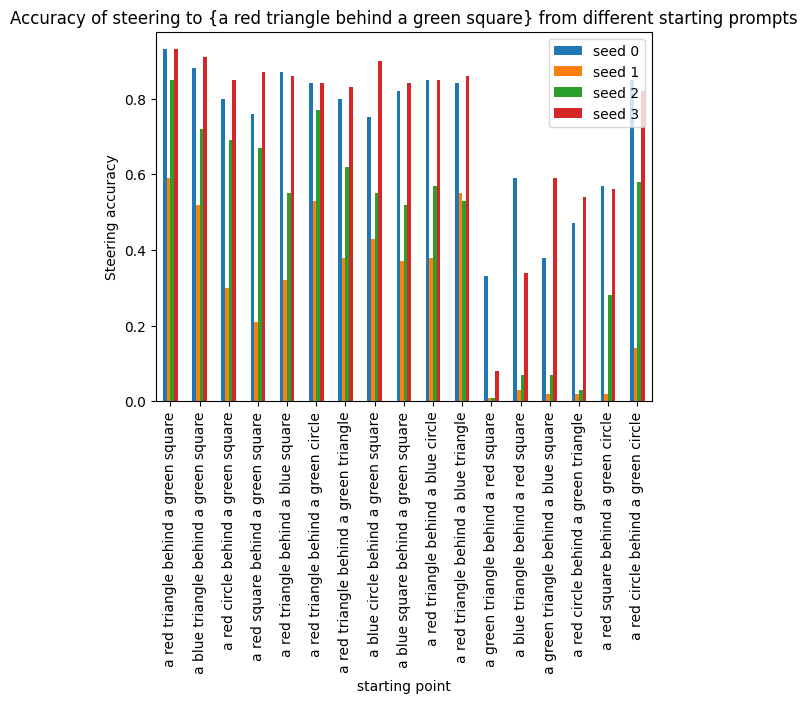

In [ ]:
df_accuracy.plot(x='starting point', y=['seed 0', 'seed 1', 'seed 2', 'seed 3'], kind='bar')
plt.ylabel('Steering accuracy')
plt.title('Accuracy of steering to {a red triangle behind a green square} from different starting prompts')
plt.show()

Seeds 1 and 3 work significantly better than before but there is still the drop in accuracy in the final starting prompts.

## Comparison of loss evolution for each of the seeds

Some models perform better than others (with respect to concept steering) depending on the random seed used to train them. Interestingly, we can tell from the loss evolution which models will perform better or worse. In the examples below, it can be seen that the loss evolution for Seed 1 is very unstable with high peaks in the loss, Seed 2 has a similar pattern although less strong. These two seeds are the ones that perform worse in steering accuracy. This suggests that a low steering accuracy may relate to the concept vector not being optimised properly (perhaps changing hyperparameters such as the learning rate would improve the convergence of the loss, but I have kept it fixed to ensure a fair comparison between random seeds).

In [ ]:
def plot_loss(index, starting_prompt):
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle(f'Starting prompt: {starting_prompt}')

    for i in range(2):
        img = mpimg.imread(f'experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_{2*i}/{index}/loss_norm_evolution_h_None.png')
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Seed {2*i}')
        axes[i, 0].axis('off')

        img = mpimg.imread(f'experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_{2*i+1}/{index}/loss_norm_evolution_h_None.png')
        axes[i, 1].imshow(img)
        axes[i, 1].set_title(f'Seed {2*i + 1}')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

### Starting prompt: a red triangle behind a green square

This is the simplest scenario, where starting prompt = end prompt.

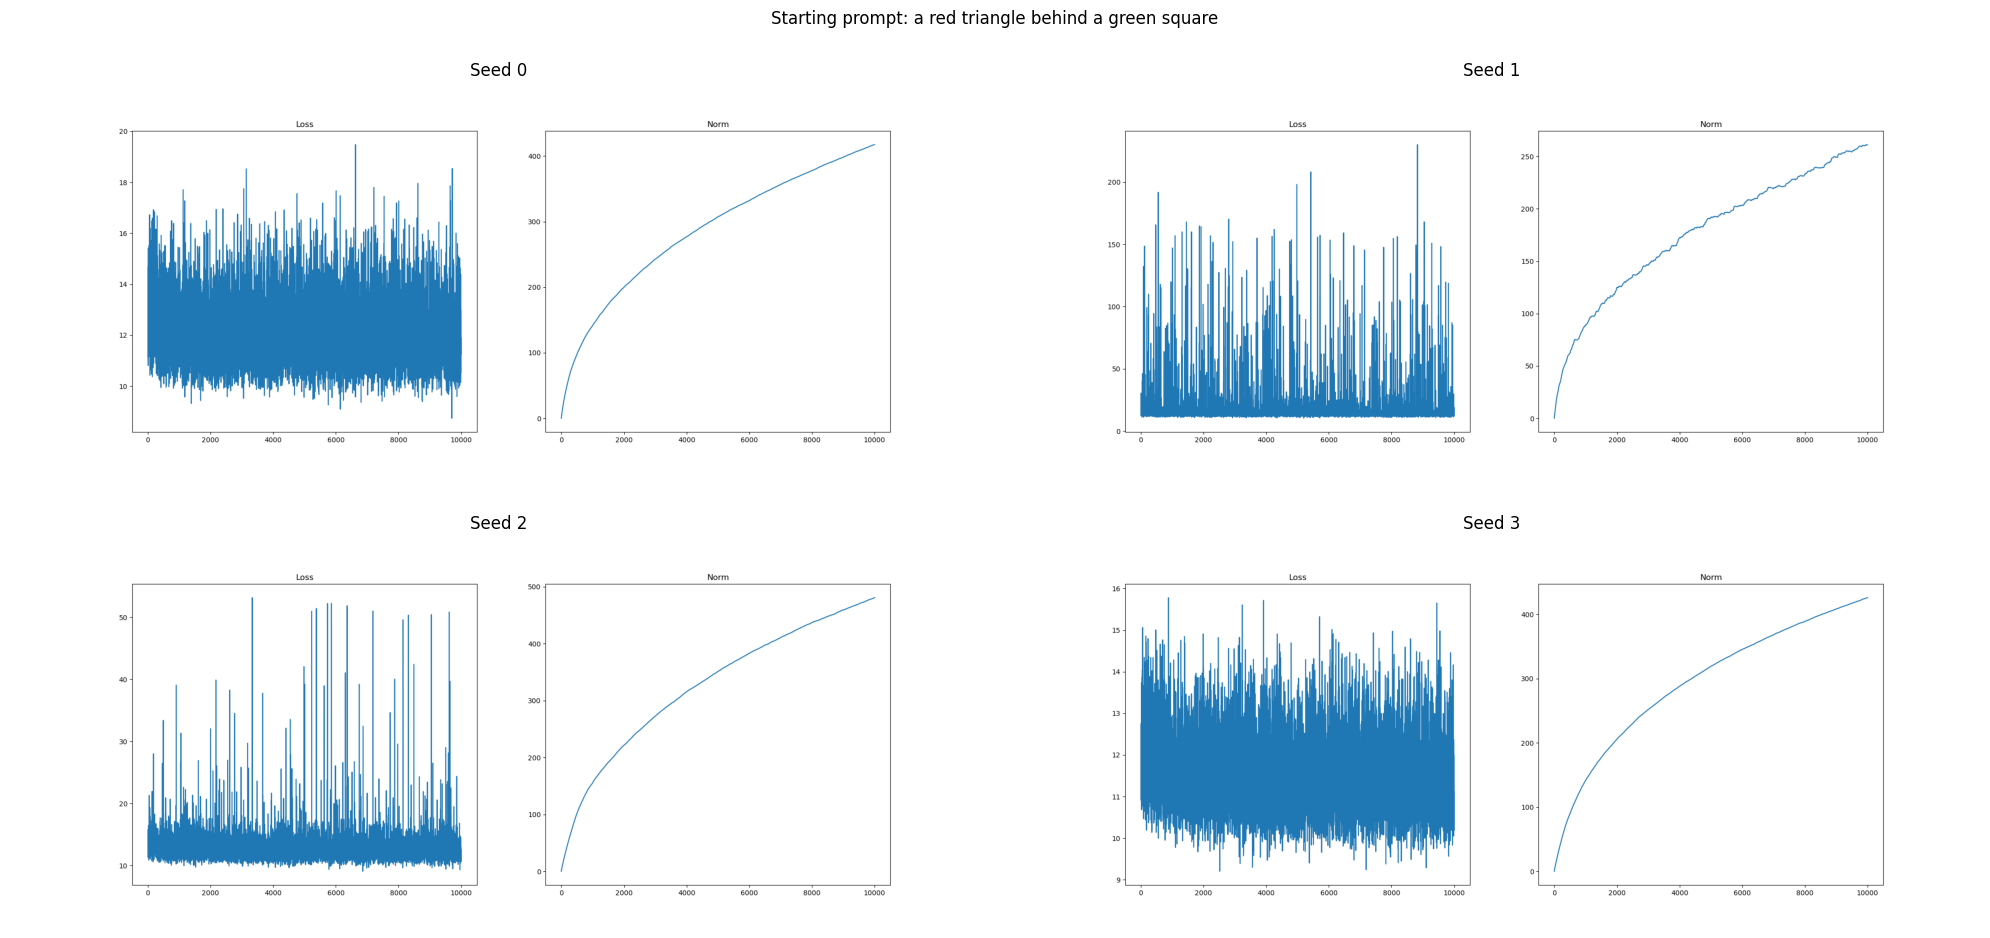

In [ ]:
starting_prompt = 'a red triangle behind a green square'
index = 0
plot_loss(index, starting_prompt)

### Starting prompt: a red square behind a green square

This is a case in which seed 0 and seed 3 work well and seed 1 and seed 2 do not.

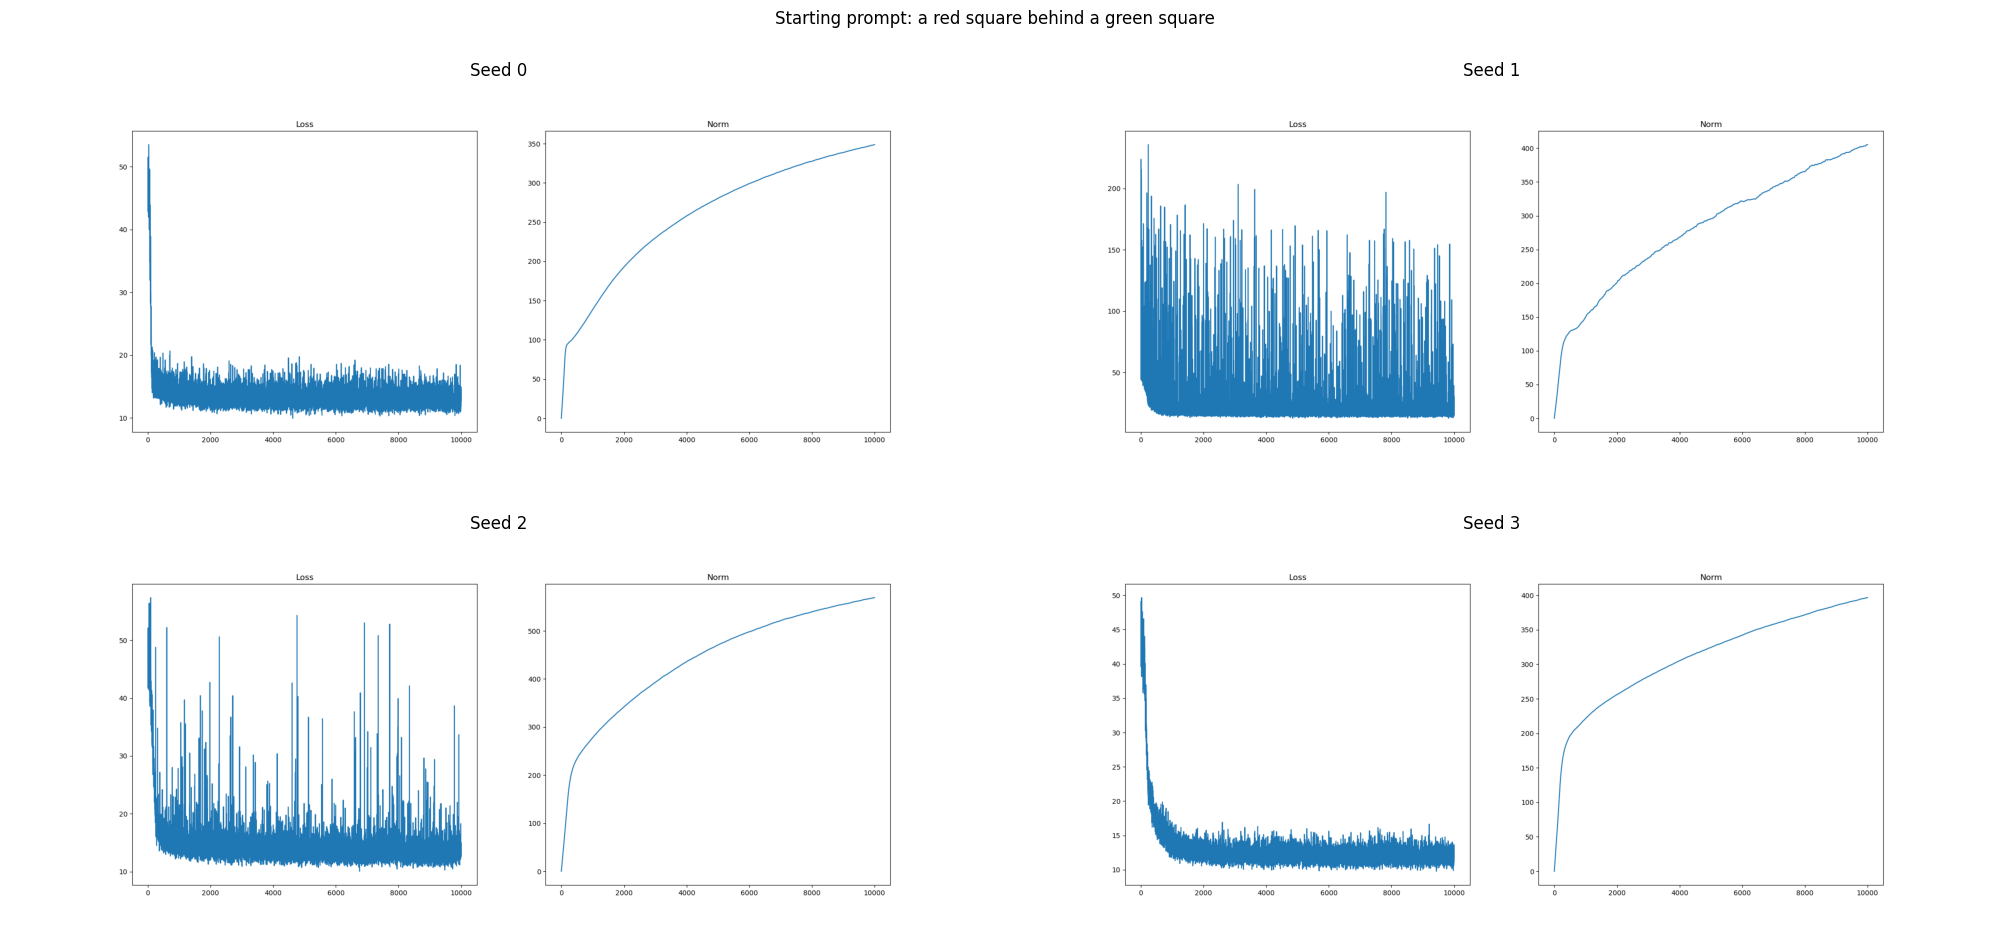

In [ ]:
starting_prompt = 'a red square behind a green square'
index = 3
plot_loss(index, starting_prompt)

### Starting prompt: a green triangle behind a red square

In this case all seeds do not perform very well, but seed 0 and seed 3 perform better. Although seed 2 has a similar trend to seed 0 and seed 3, the loss reaches a lower value for 0 and 3.

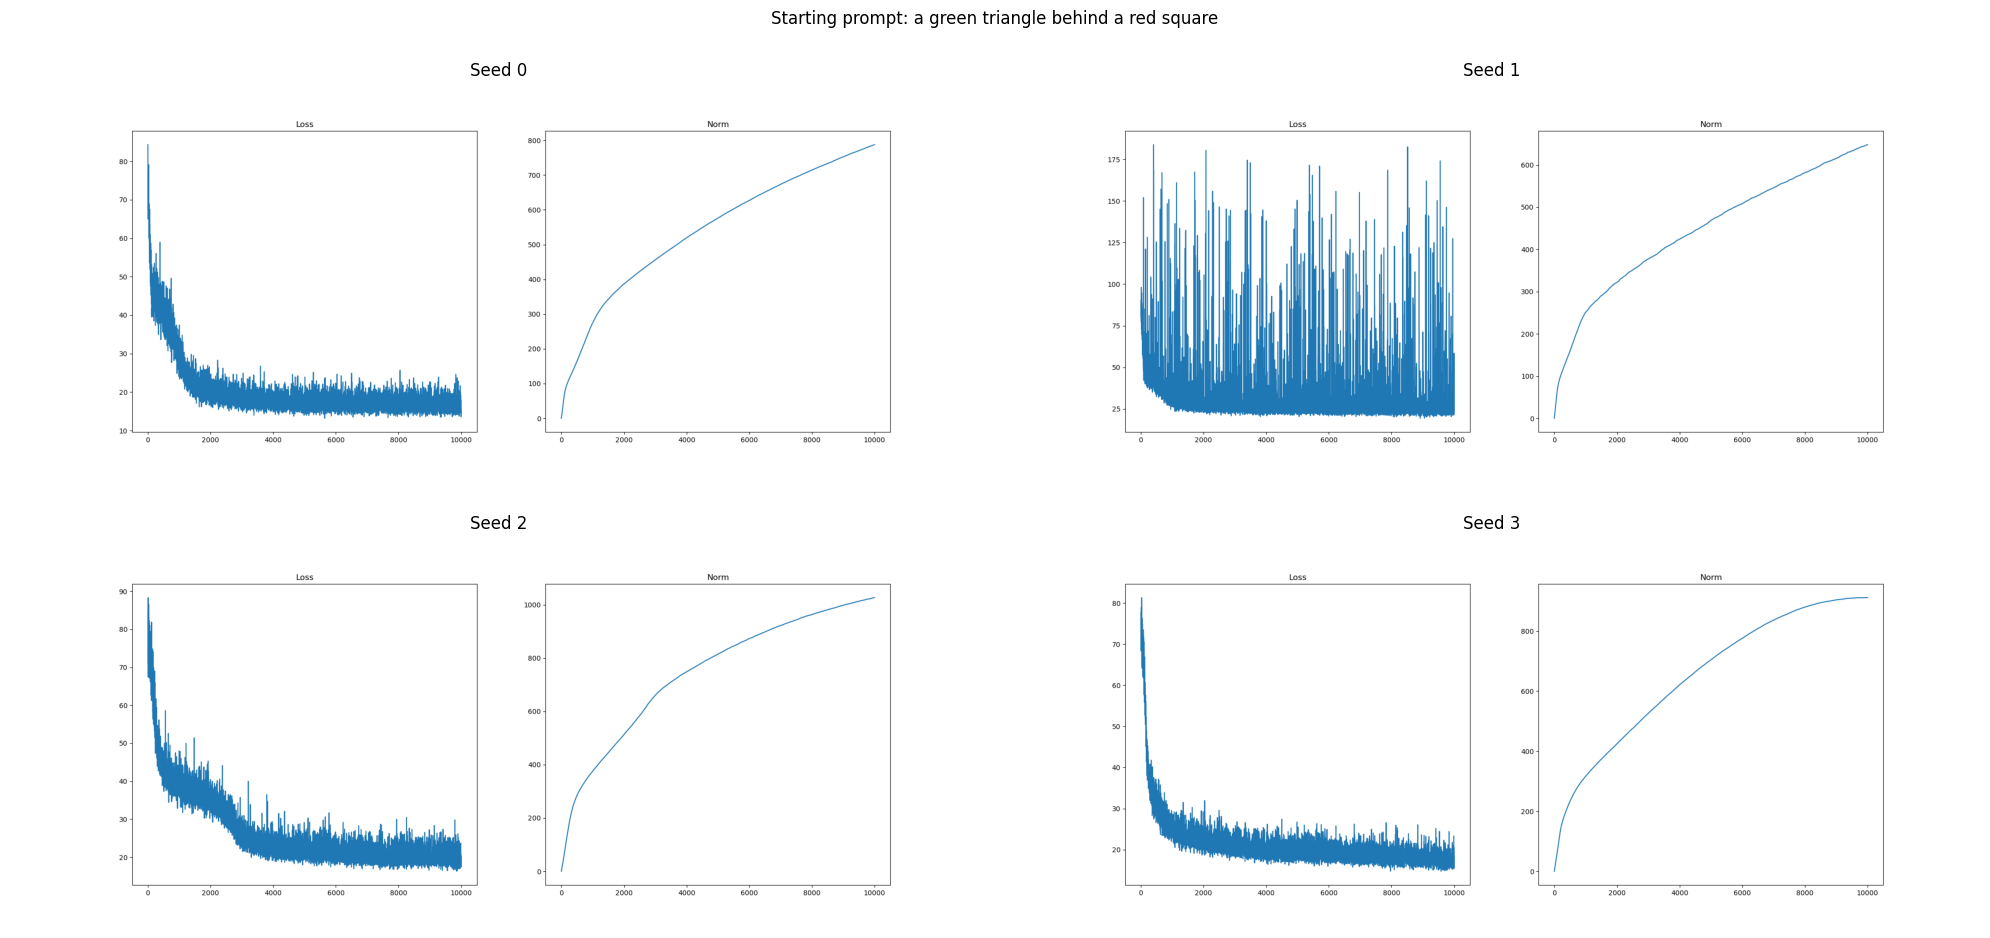

In [ ]:
starting_prompt = 'a green triangle behind a red square'
index = 11
plot_loss(index, starting_prompt)

# Scatter plots for relation of metrics to accuracy

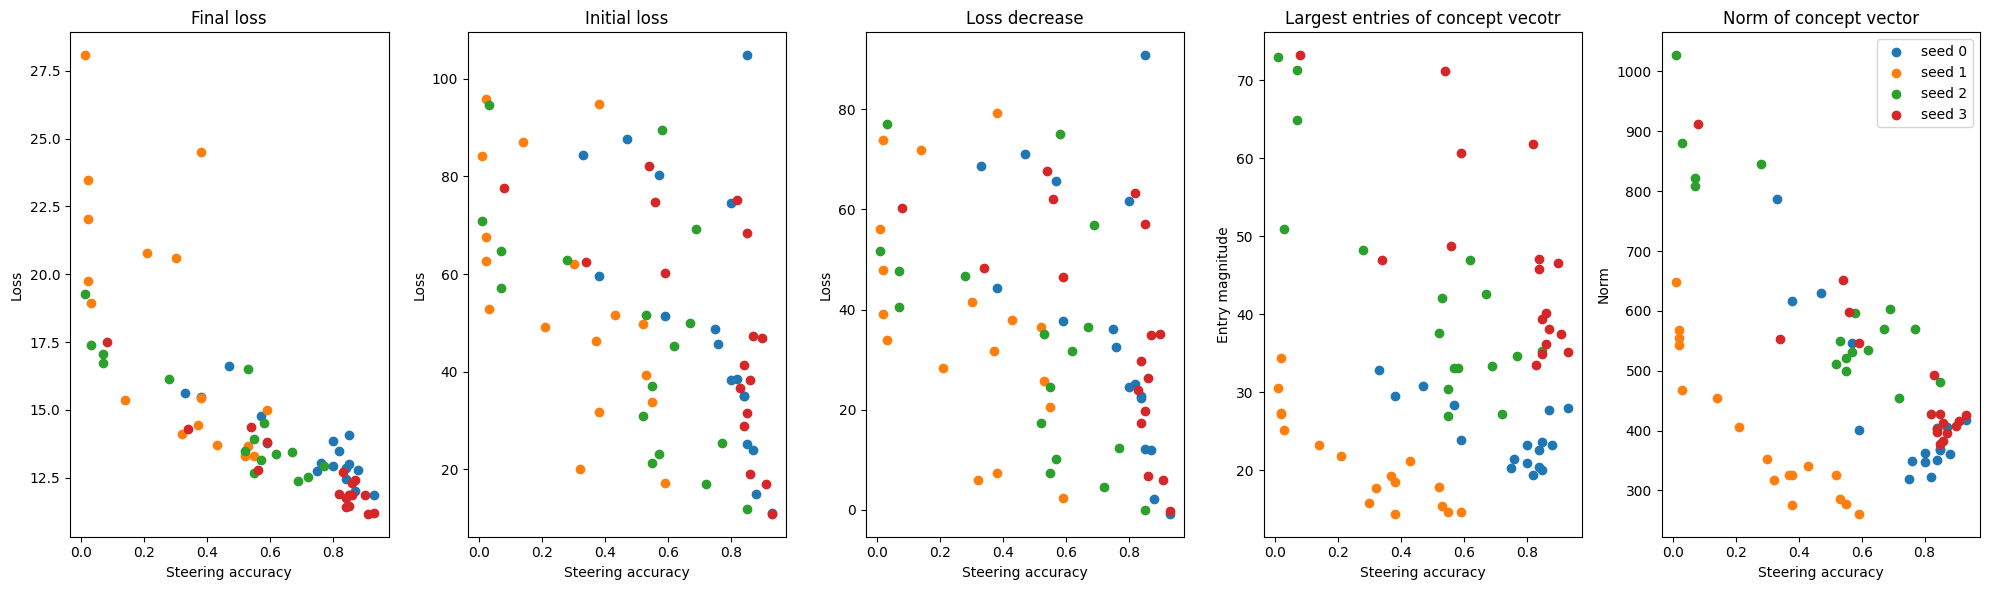

In [ ]:
titles = ['Final loss', 'Initial loss', 'Loss decrease', 'Largest entries of concept vecotr', 'Norm of concept vector']
ylabels = ['Loss', 'Loss', 'Loss', 'Entry magnitude', 'Norm']
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharex=True)

i = 0
for df in [df_final_loss, df_initial_loss, df_loss_diff, df_largest, df_norm]:
    for j in range(4):
        axes[i].scatter(df_accuracy[f'seed {j}'], df[f'seed {j}'], label=f'seed {j}')
    axes[i].set_title(titles[i])
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_xlabel('Steering accuracy')
    i += 1

plt.legend()
plt.tight_layout()
plt.show()

From the above plots, it is clear that a high final loss leads to a low steering accuracy. Also, there is a clear negative pattern for the norm of the concept vector, where a large norm is also related to a low accuracy (seed 1 seems to follow a different linear relation to the other seeds - this was the model that performed the worst).

Note that initial loss/loss decrease can be indicative of the number of components $c_1, s_1, c_2, s_2$ that have to be changed to steer from the starting point to the end point. Two components generally have a larger initial loss/loss decrease than 1 or 0 components being changed.

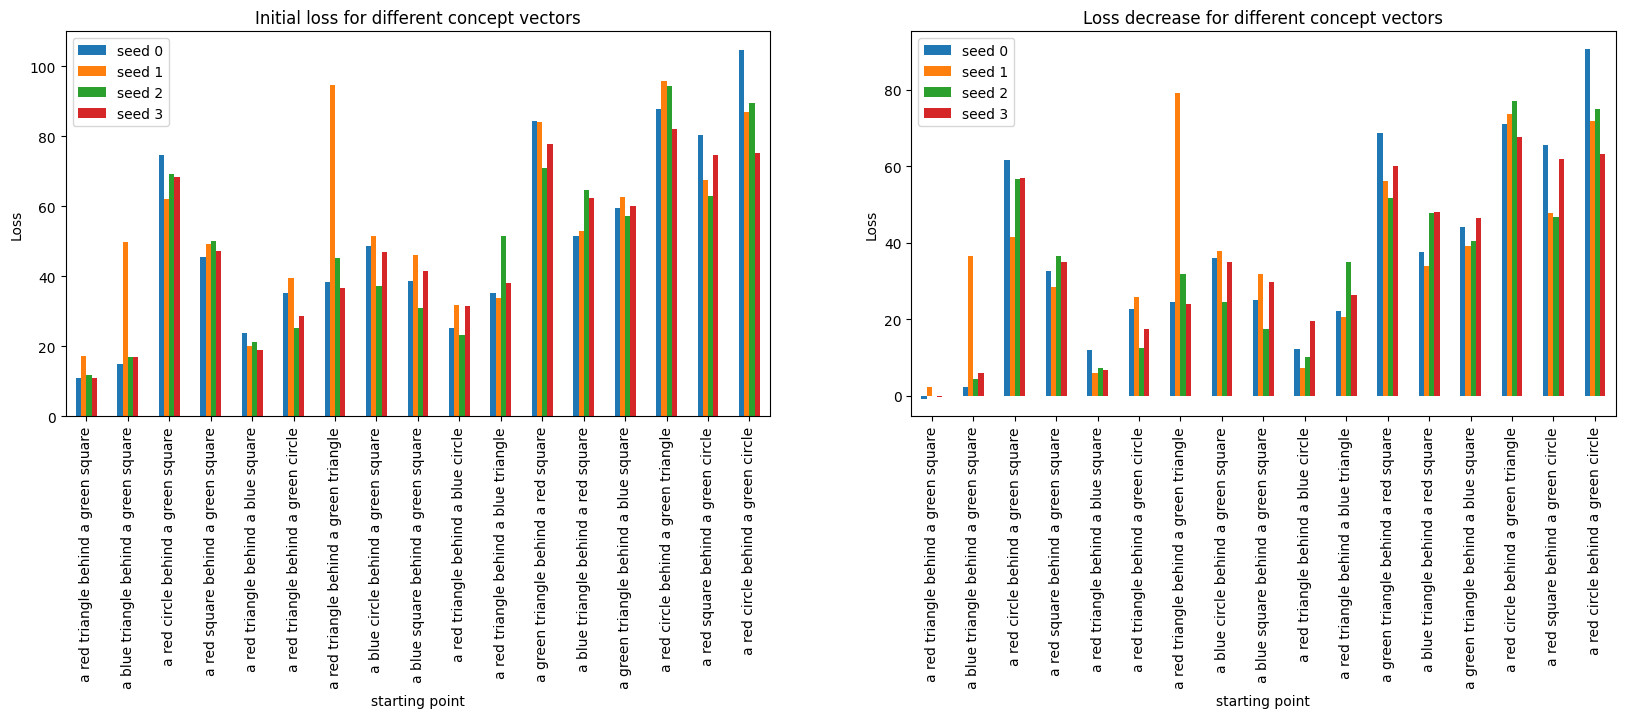

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)

df_initial_loss.plot(ax=axes[0], x='starting point', y=['seed 0', 'seed 1', 'seed 2', 'seed 3'], kind='bar')
axes[0].set_title('Initial loss for different concept vectors')
axes[0].set_ylabel('Loss')

df_loss_diff.plot(ax=axes[1], x='starting point', y=['seed 0', 'seed 1', 'seed 2', 'seed 3'], kind='bar')
axes[1].set_title('Loss decrease for different concept vectors')
axes[1].set_ylabel('Loss')


plt.show()

Note that a higher initial loss does not necessarily produce lower accuracy (e.g., the last starting prompt "a red circle behind a green circle" produces one of the highest initial losses but has a better steering accuracy than

# Steering using vectors obtained at earlier stages of concept optimisation process

Results for seed 0 and seed 3 are shown, as they show the best performance when using the final concept vector. As the concept vector is optimised, adding it in the sampling stage will gradually change the obtained images from the description in the starting prompt to the description in the end prompt. We store checkpoints of the concept vector at iterations 50, 500, 1000, 2500, 5000, 7500 and 10000. Performance matches the decrease in the loss that is observed during the optimisation process.

In [ ]:
def plot_images_different_vectors(index, starting_prompt, seed):
    fig, axes = plt.subplots(1, 7, figsize=(30, 5))
    fig.suptitle(f'Seed {seed}, end point: a red triangle behind a green square')

    i = 0
    for j in [50, 500, 1000, 2500, 5000, 7500]:
        img = mpimg.imread(f'experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_{seed}/{index}/samples_{starting_prompt}/grid_samples_concept_edit_h_{j}.png')

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_xlabel(f'Iteration {j}')

        i += 1

    img = mpimg.imread(f'experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_{seed}/{index}/samples_{starting_prompt}/grid_samples_concept_edit_h_None.png')

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_xlabel(f'Iteration 10000')

    plt.show()

def plot_vector(concept_vector, title):
    concept_vector = torch.flatten(concept_vector).detach().numpy()

    fig = plt.figure(figsize=(20, 3))
    plt.scatter(range(len(concept_vector)), concept_vector, s=1)
    plt.title(title)
    plt.ylim([-80, 80])
    plt.show()

These are three examples of how the accuracy evolves over time, but after that I show the results for different starting prompts on a graph.

### Example: a red triangle behind a blue square

Note: this is not very visible, but the idea is that as the steering progresses the number of images with the end point increases.

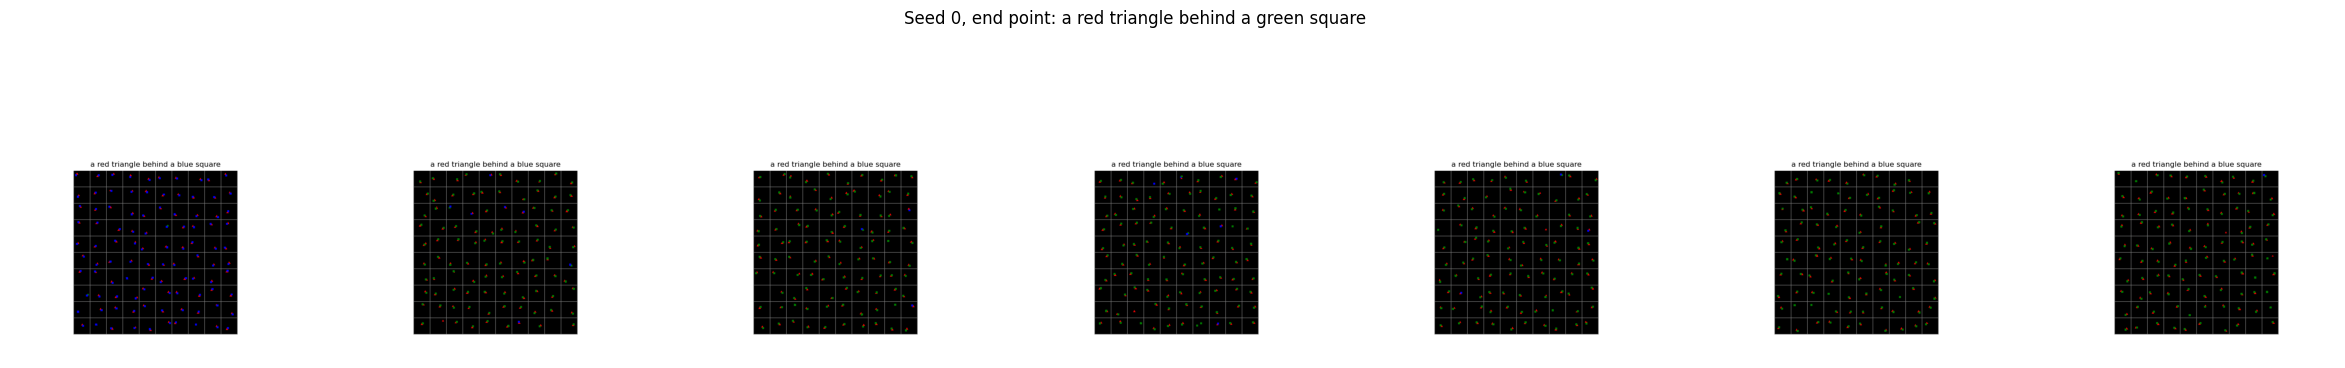

In [ ]:
index = 4
starting_prompt = 'a red triangle behind a blue square'
seed = 0
plot_images_different_vectors(index, starting_prompt, seed)

The loss evolution to the corresponding optimisation process:

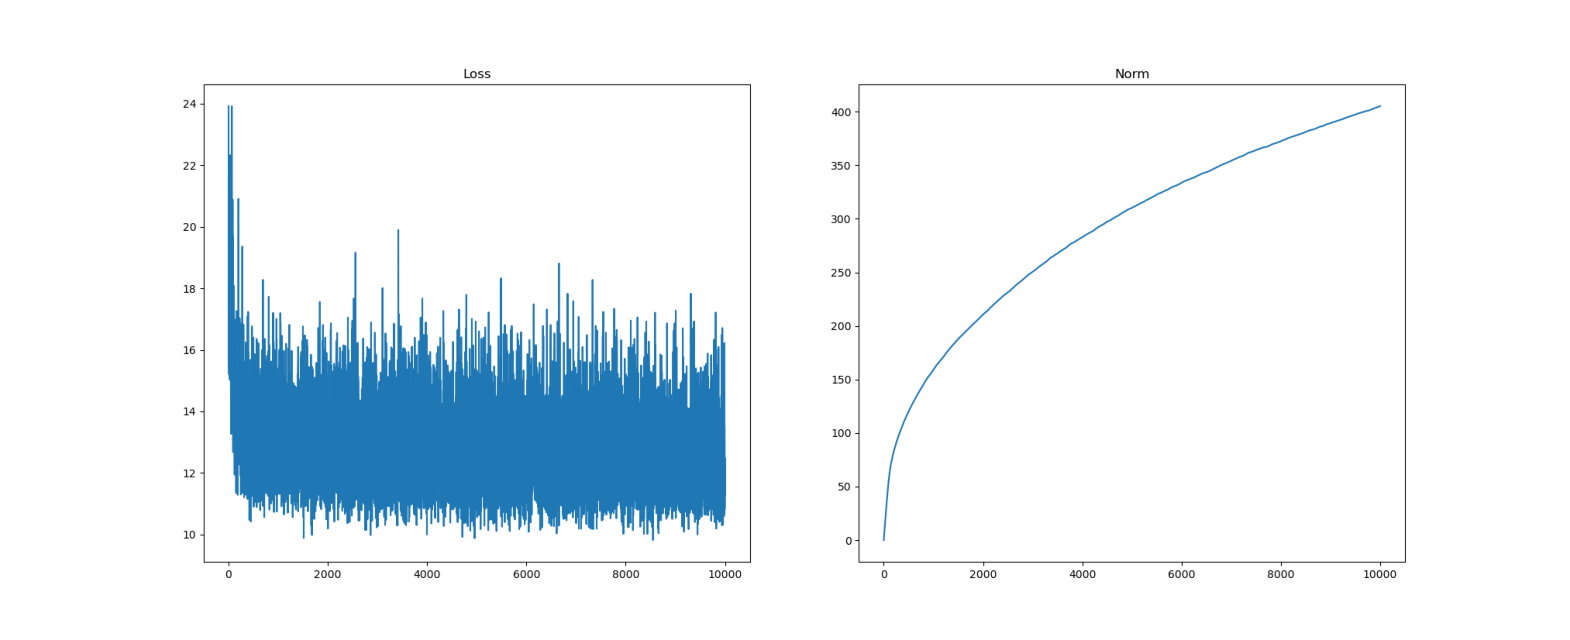

In [ ]:
img = mpimg.imread(f'experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_0/4/loss_norm_evolution_h_None.png')

fig = plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

We can also visualise how the concept vector is changing over the different iteration steps. Below are scatter plots of the value of each entry in the concept vector when flattened.

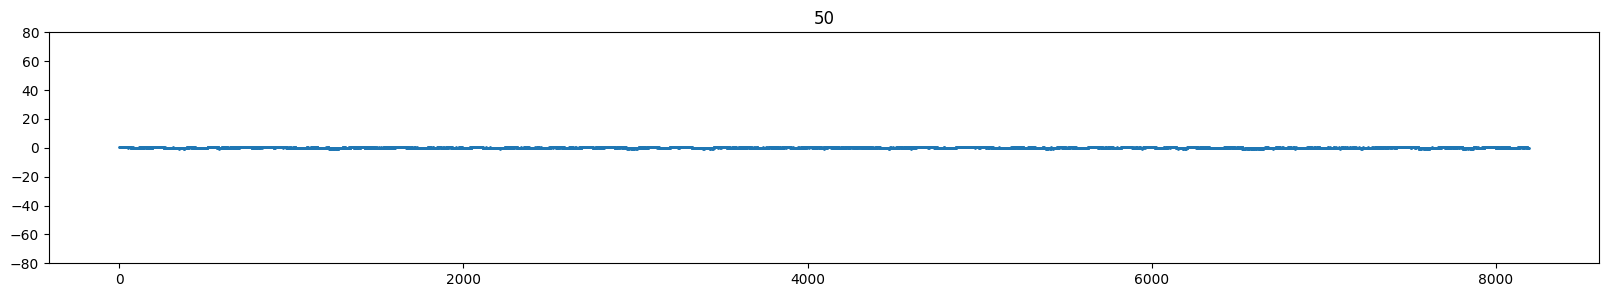

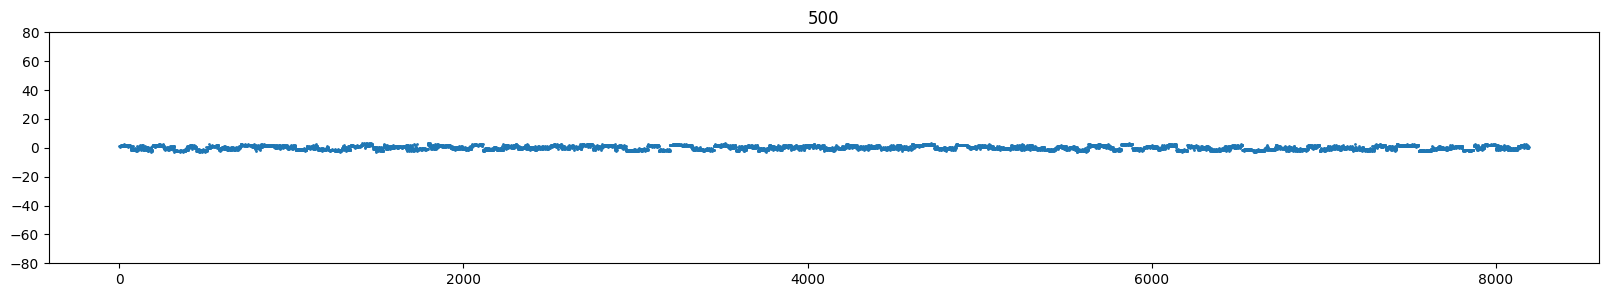

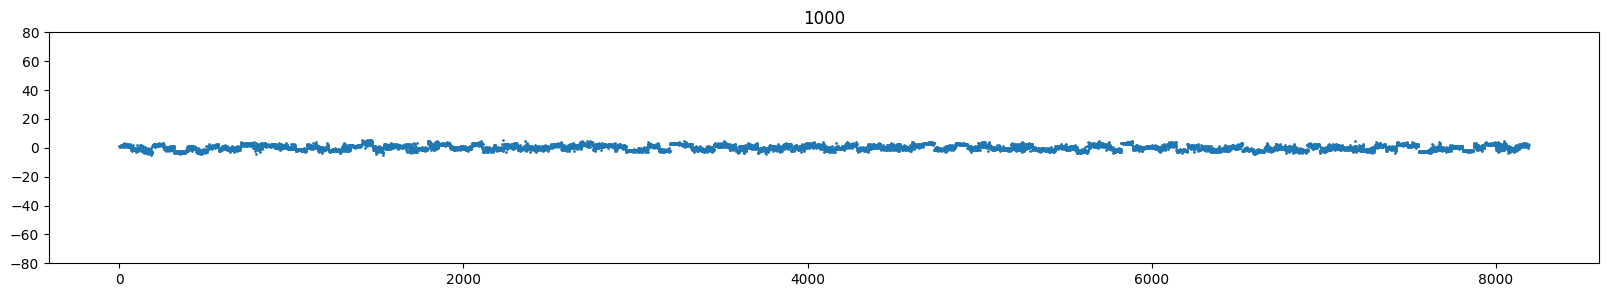

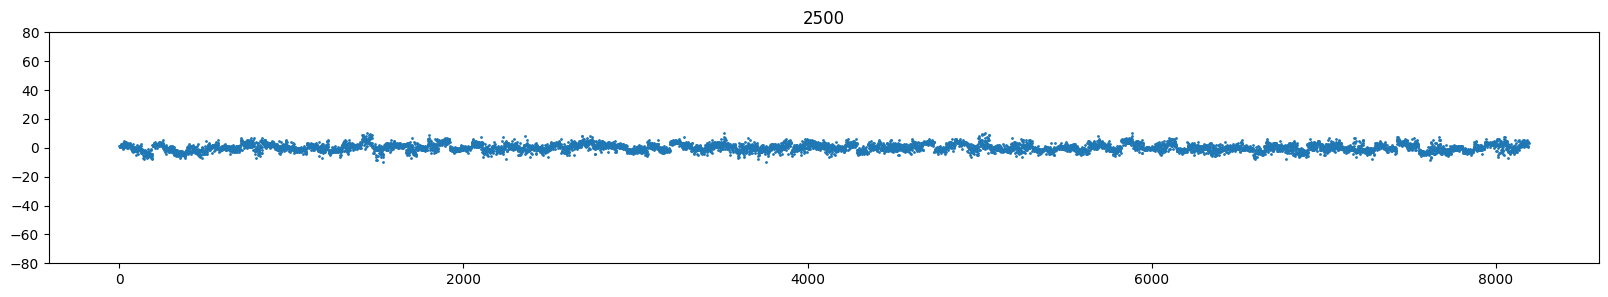

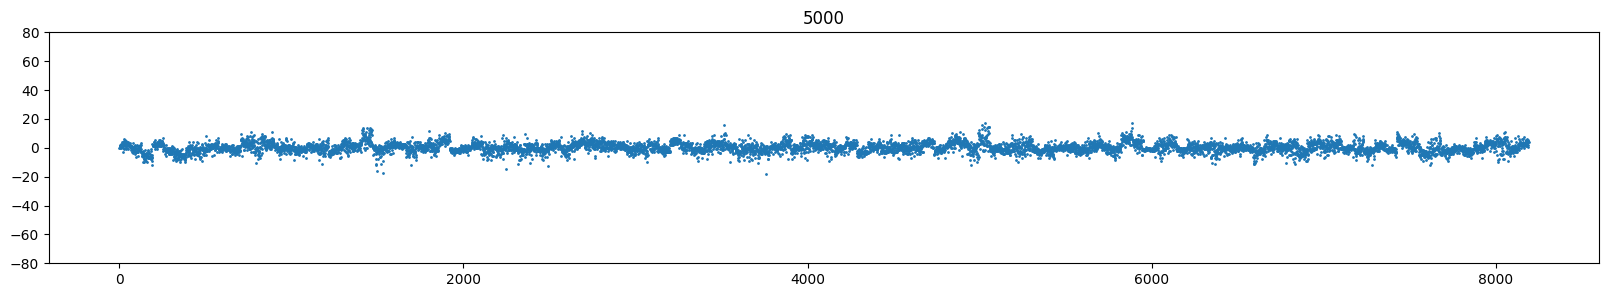

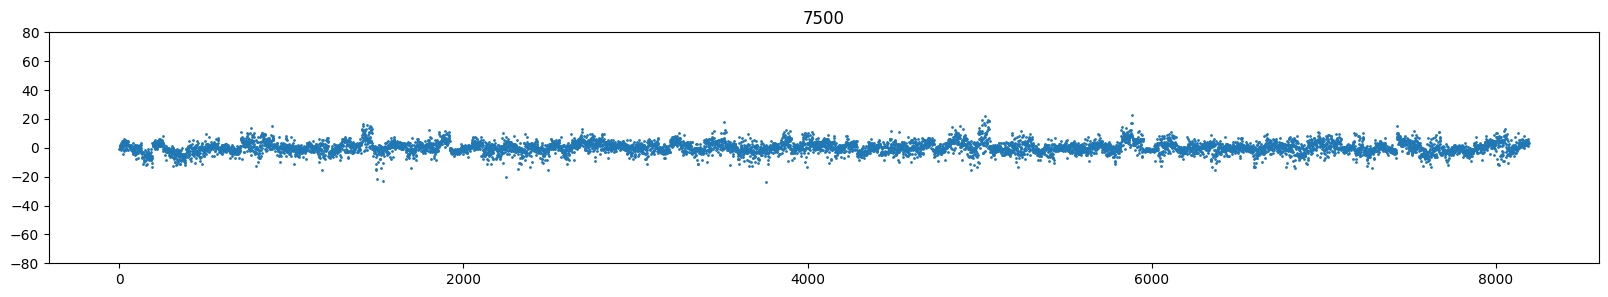

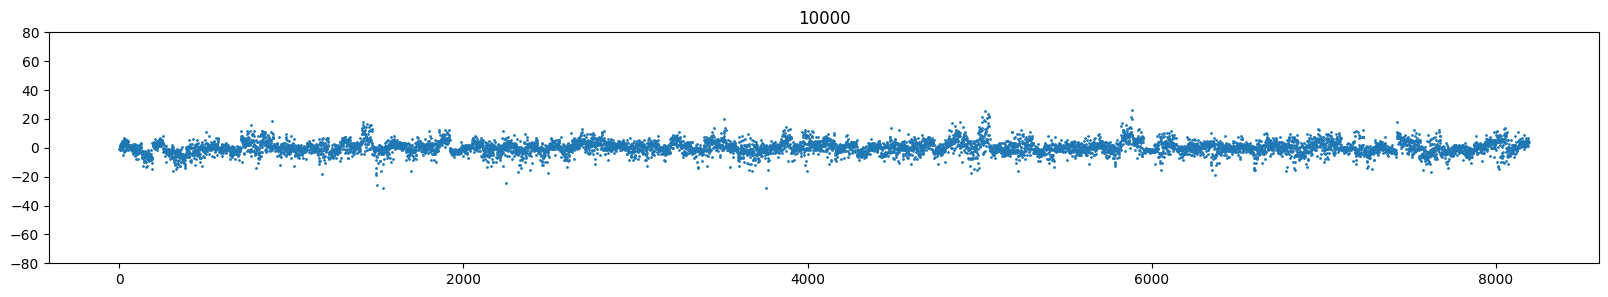

In [ ]:
vector_dict = torch.load('experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_0/4/vector_dict.json', map_location=torch.device('cpu'), weights_only=True)

for key in vector_dict.keys():
    c_vec = vector_dict[key]
    plot_vector(c_vec, key)

c_vec = torch.load('experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_0/4/concept_vectors_h_None.pt', map_location=torch.device('cpu'), weights_only=True)
plot_vector(c_vec, '10000')

### Example: a blue square behind a green square

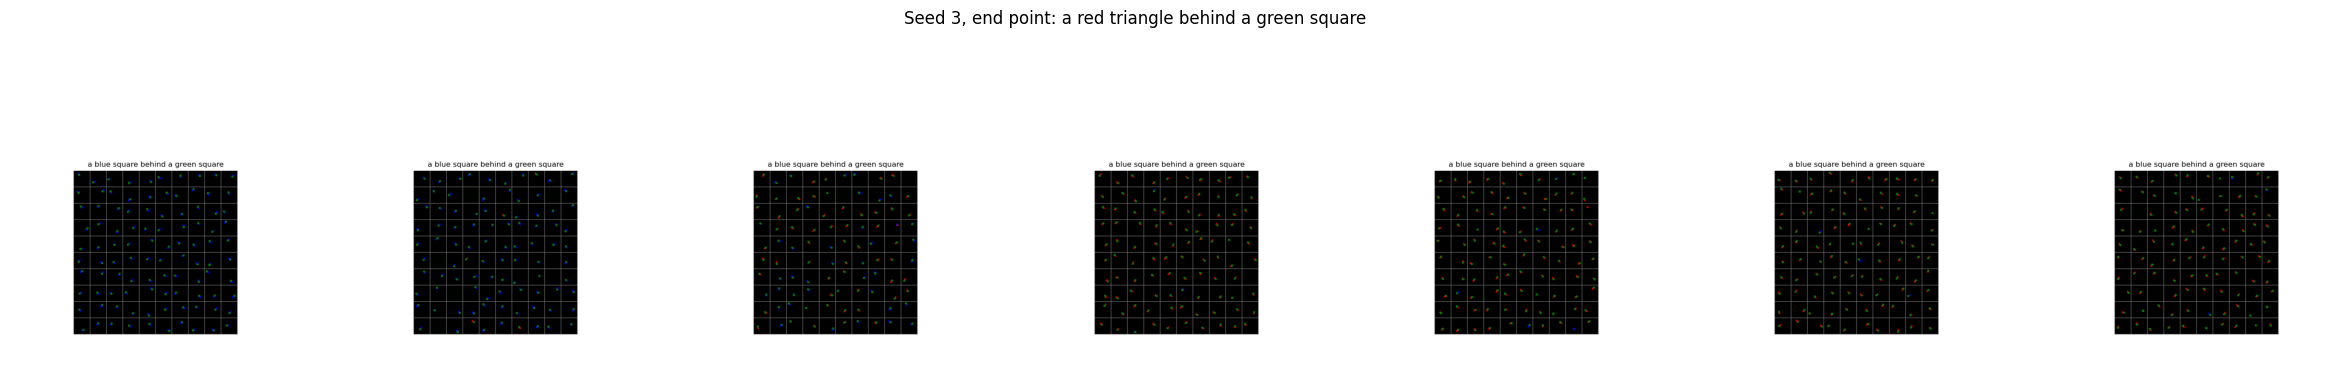

In [ ]:
index = 8
starting_prompt = 'a blue square behind a green square'
seed = 3
plot_images_different_vectors(index, starting_prompt, seed)

The loss evolution to the corresponding optimisation process:

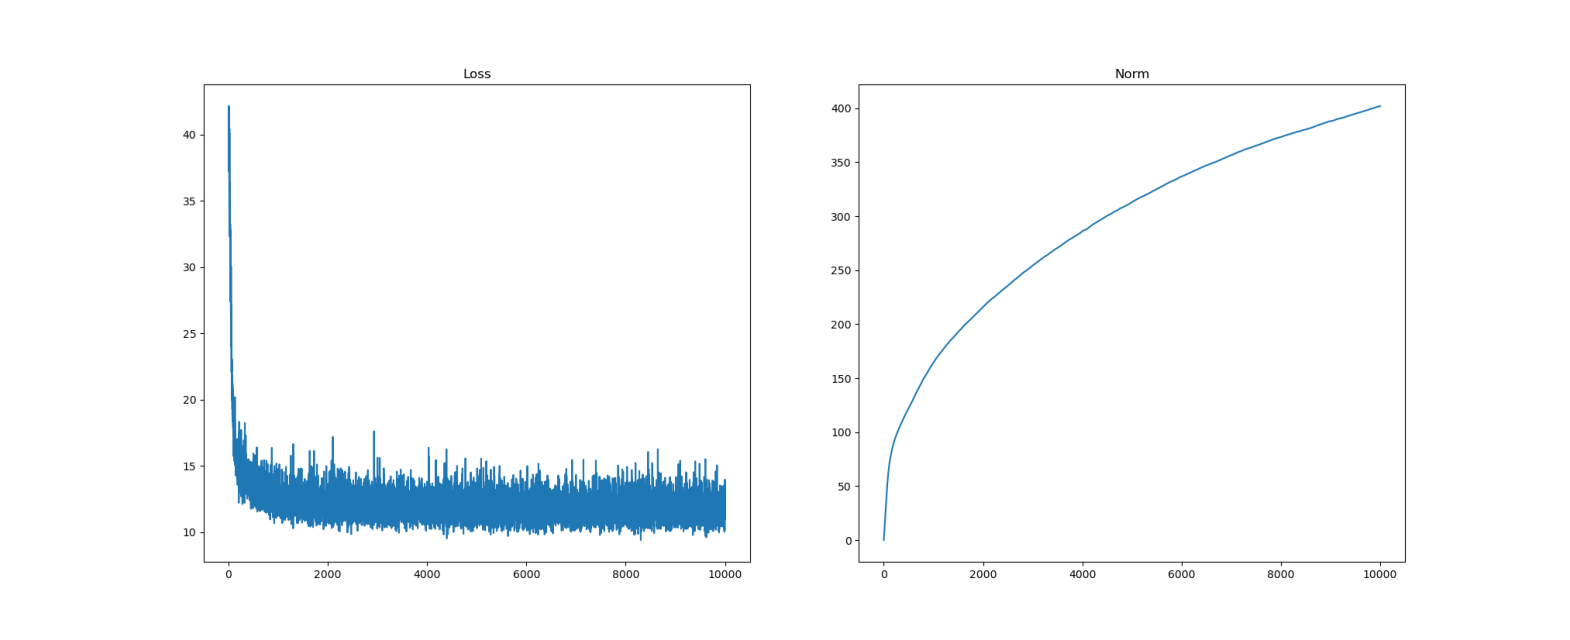

In [ ]:
img = mpimg.imread(f'experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_3/8/loss_norm_evolution_h_None.png')

fig = plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

By the 2500'th iteration the loss has slowed down when decreasing however the concept vector entries continue to grow.

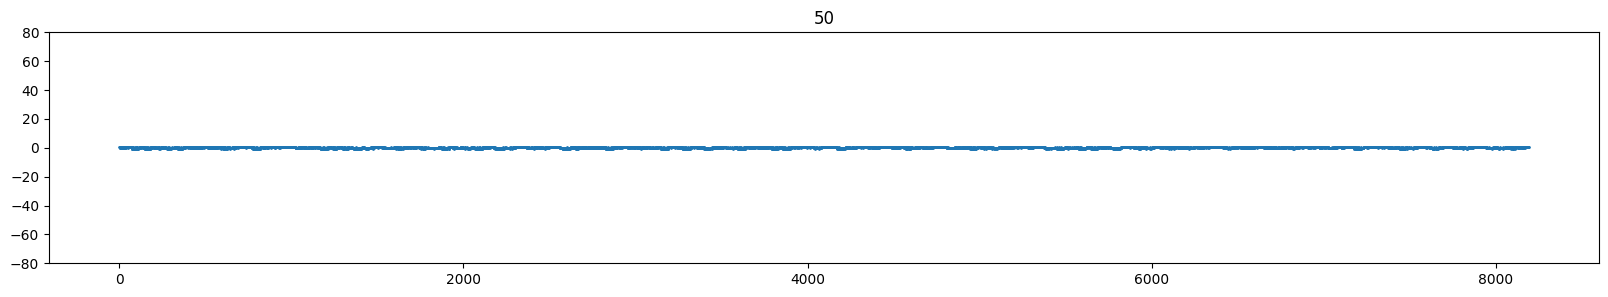

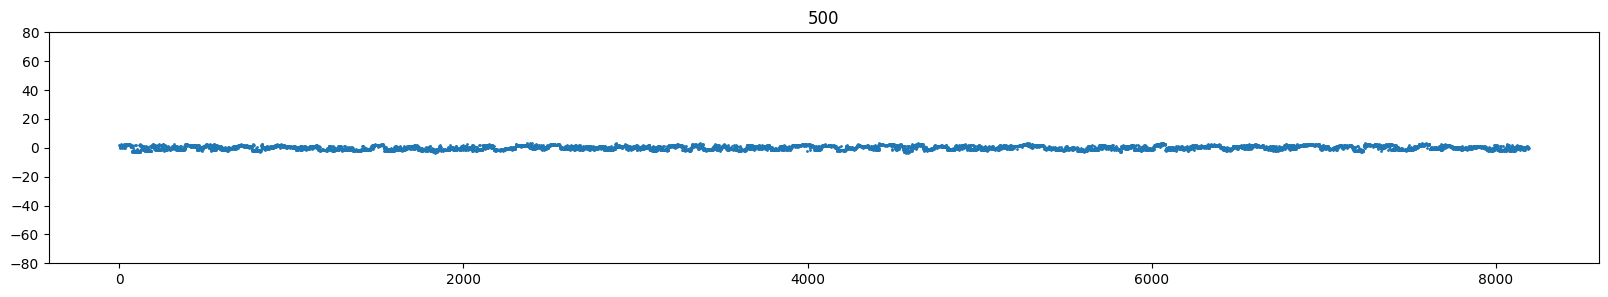

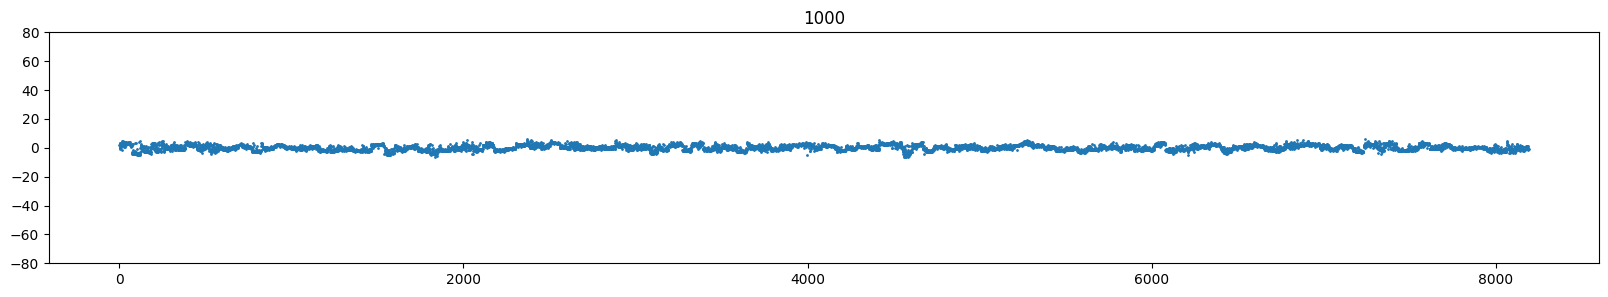

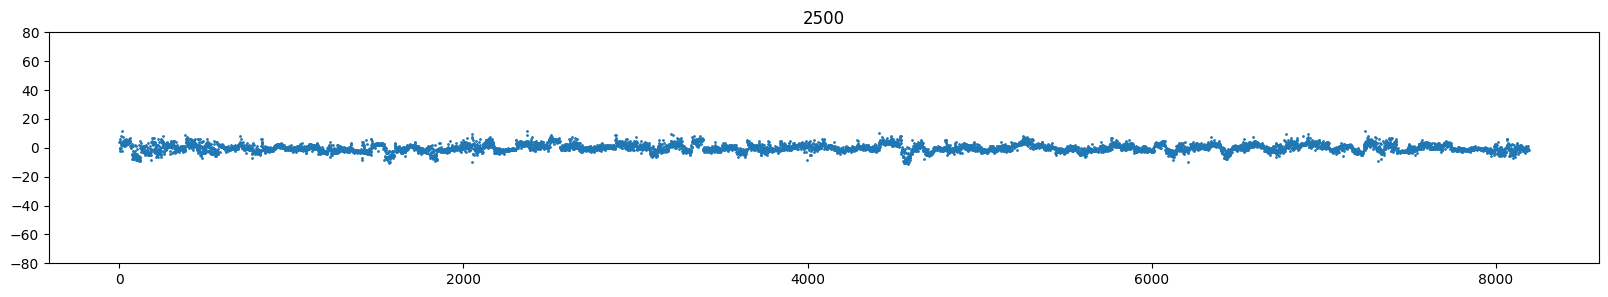

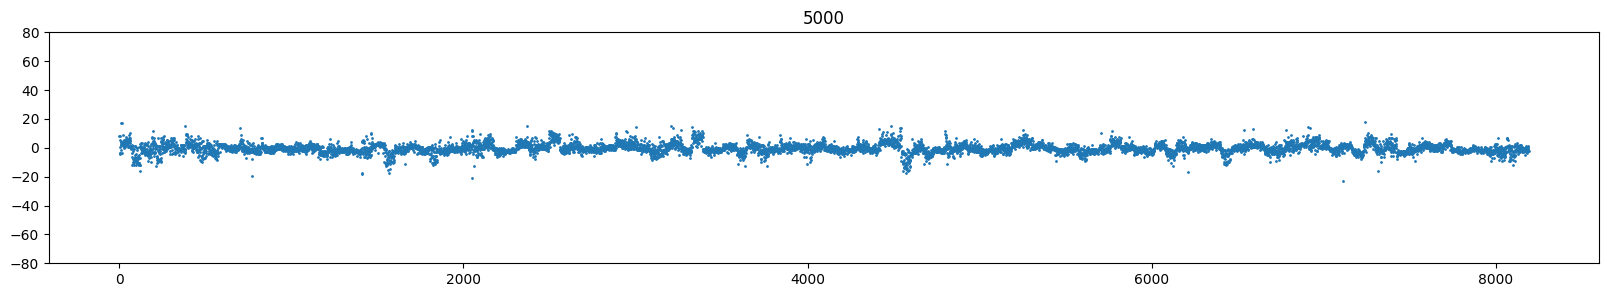

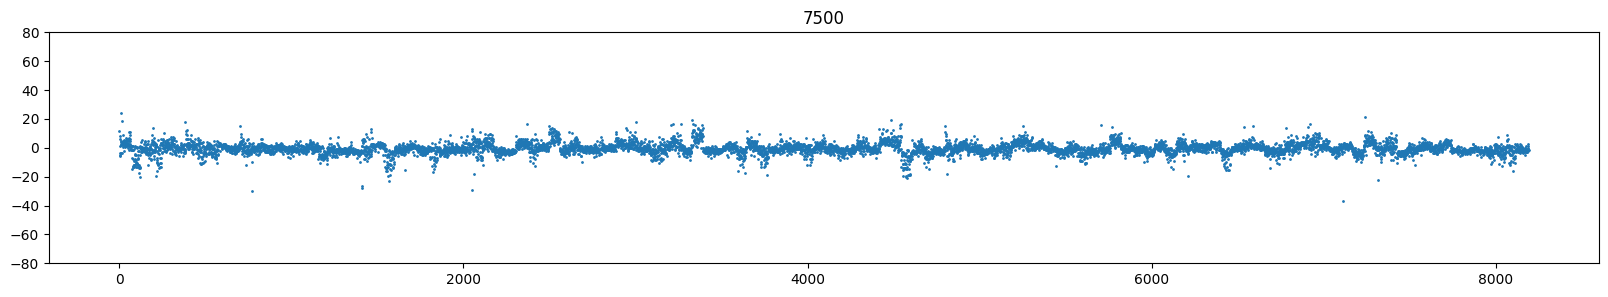

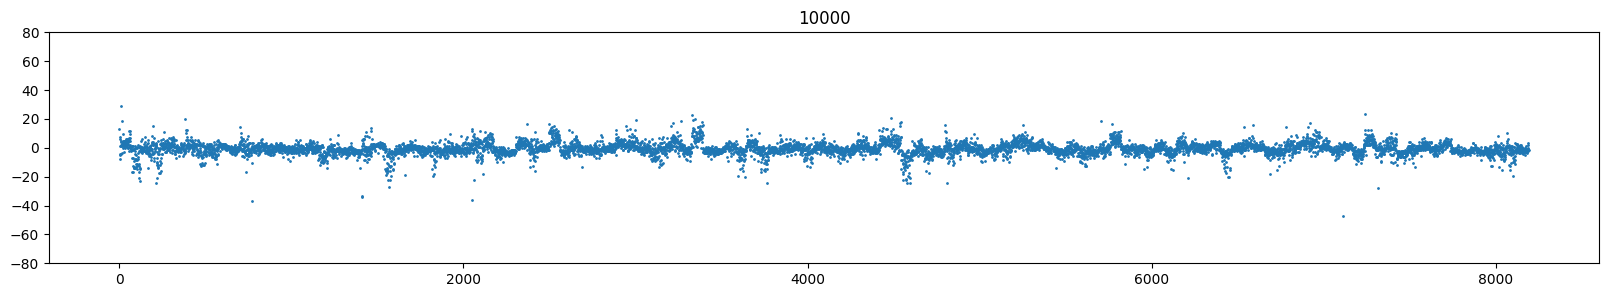

In [ ]:
vector_dict = torch.load('experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_3/8/vector_dict.json', map_location=torch.device('cpu'), weights_only=True)

for key in vector_dict.keys():
    c_vec = vector_dict[key]
    plot_vector(c_vec, key)

c_vec = torch.load('experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_3/8/concept_vectors_h_None.pt', map_location=torch.device('cpu'), weights_only=True)
plot_vector(c_vec, '10000')

### Example: a blue triangle behind a red square

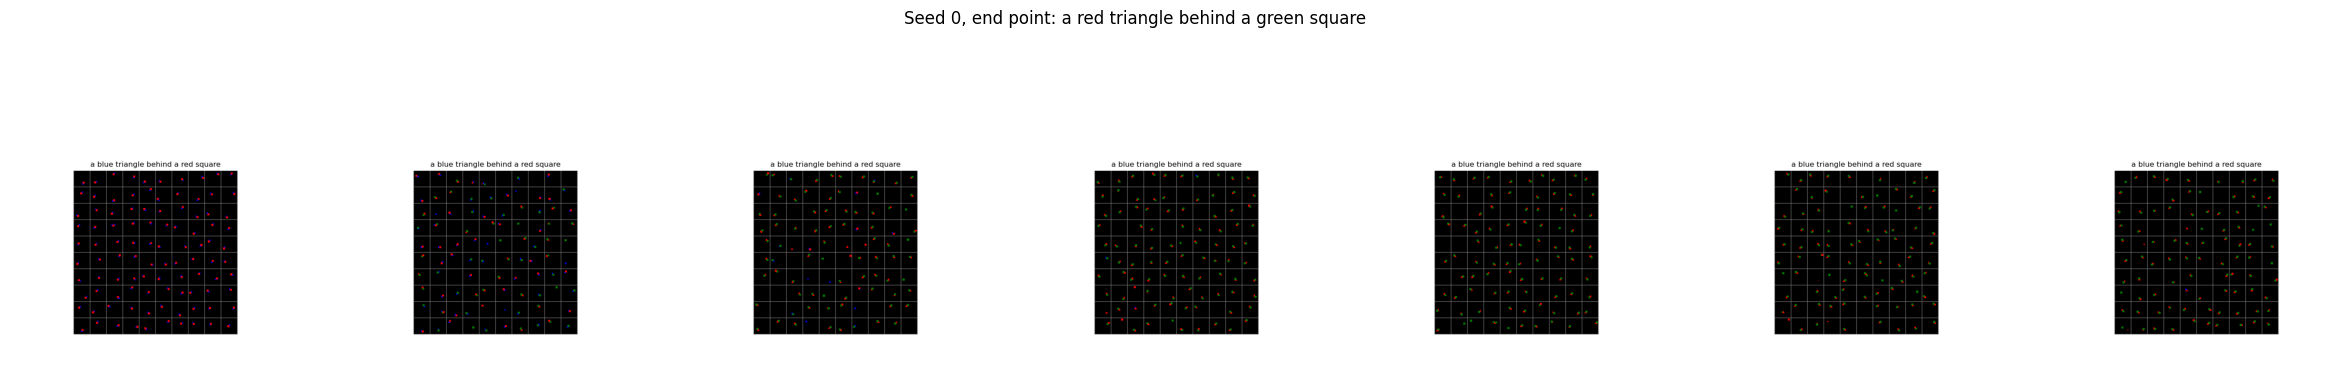

In [ ]:
index = 12
starting_prompt = 'a blue triangle behind a red square'
seed = 0
plot_images_different_vectors(index, starting_prompt, seed)

The loss evolution to the corresponding optimisation process:

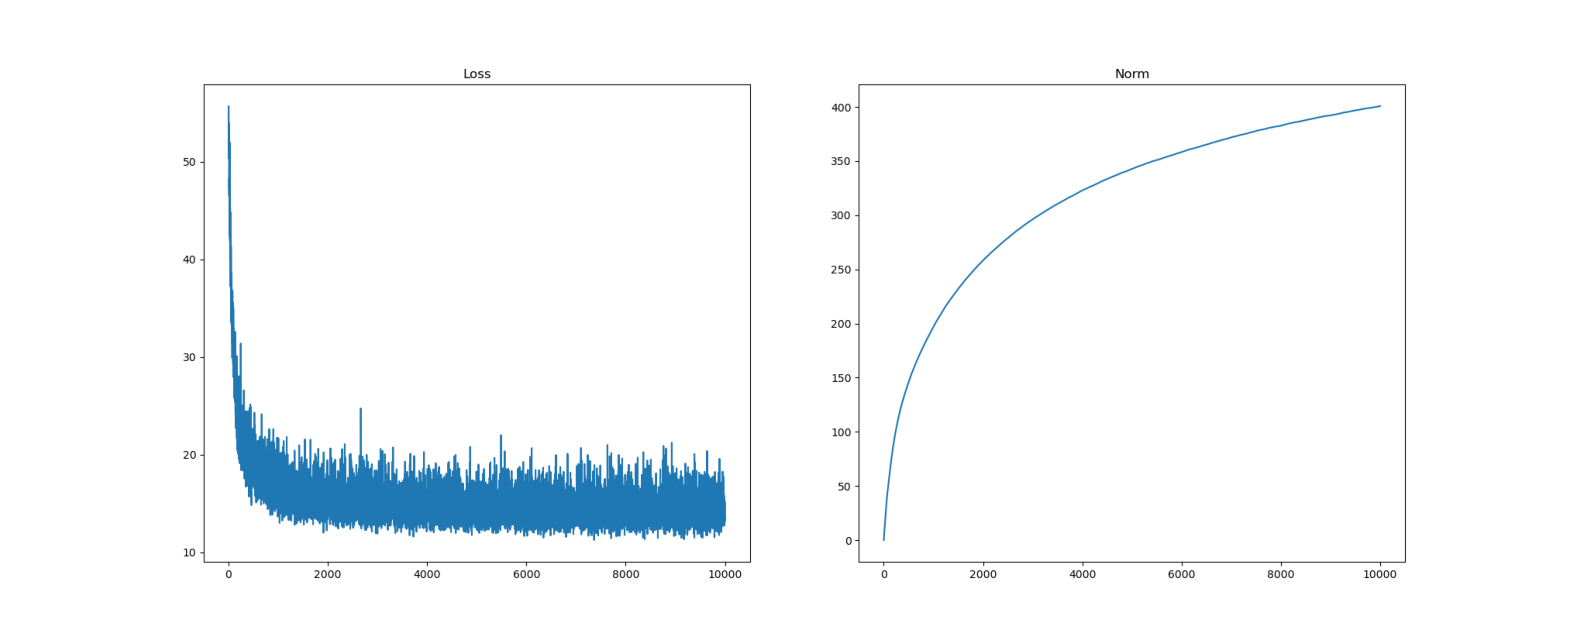

In [ ]:
img = mpimg.imread(f'experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_0/12/loss_norm_evolution_h_None.png')

fig = plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

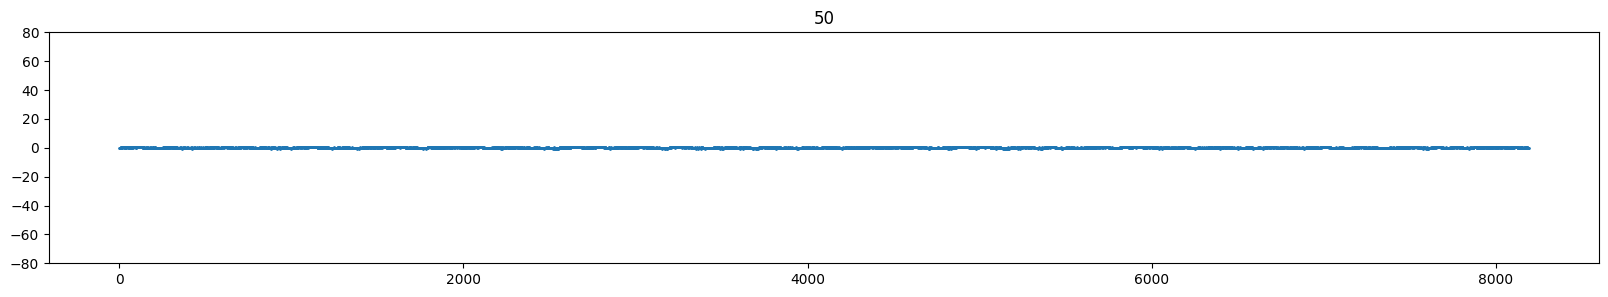

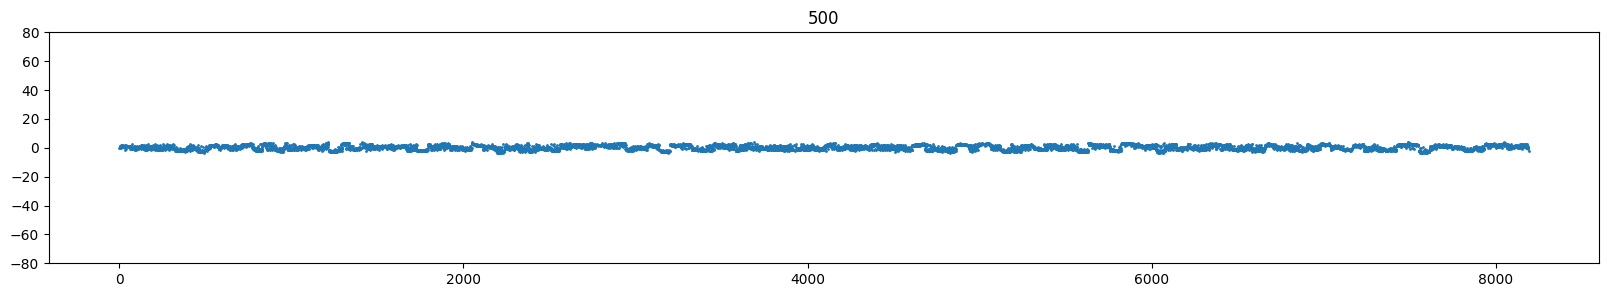

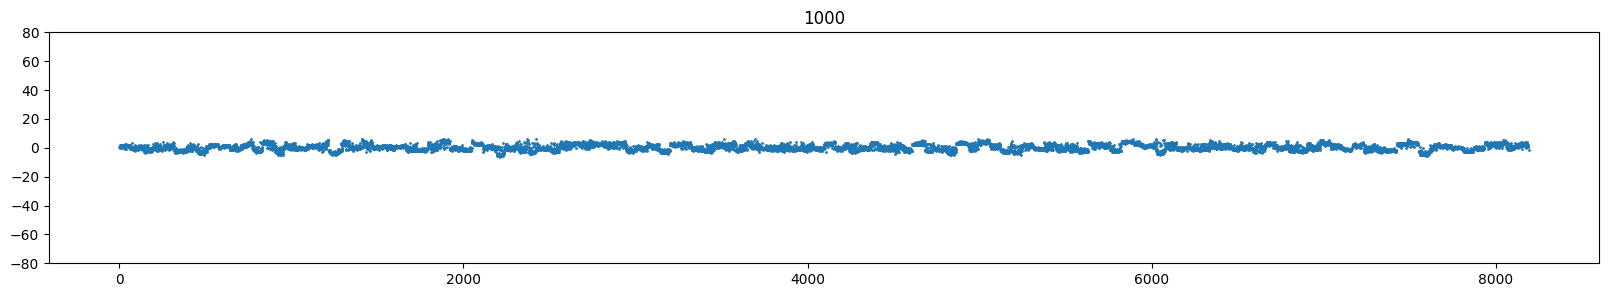

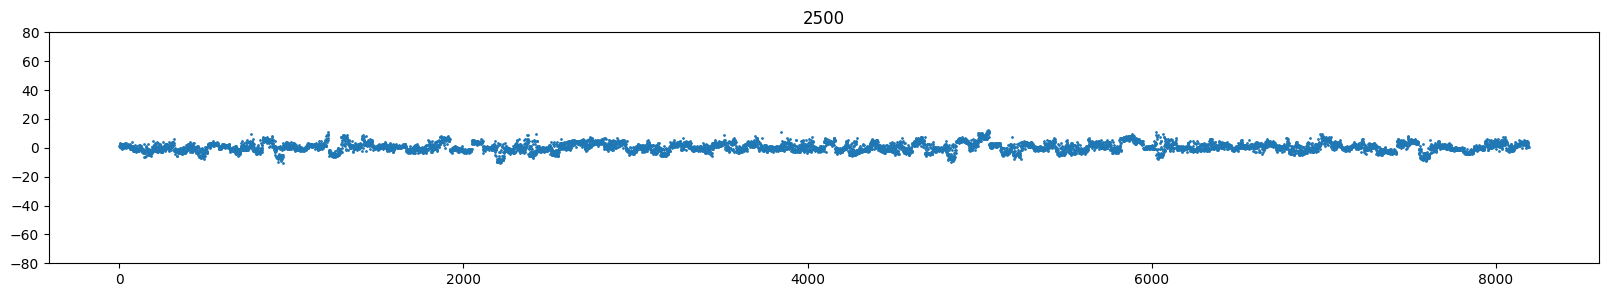

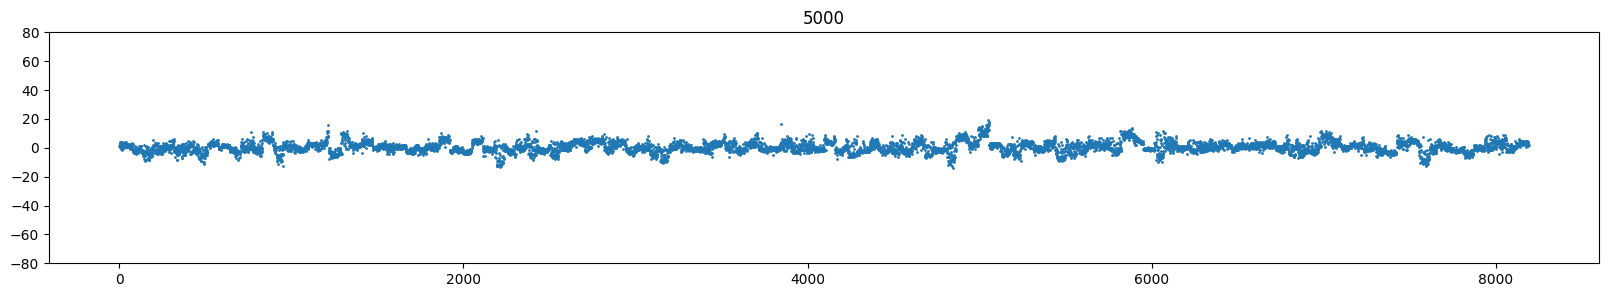

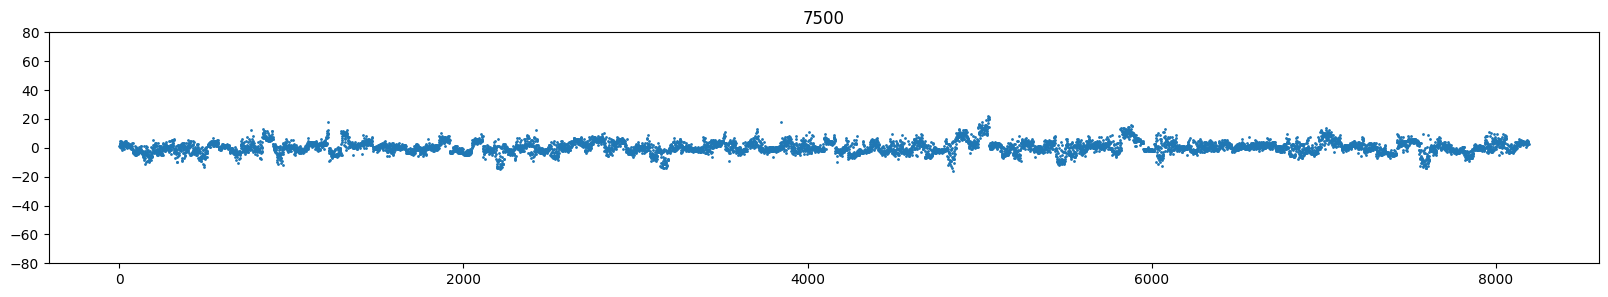

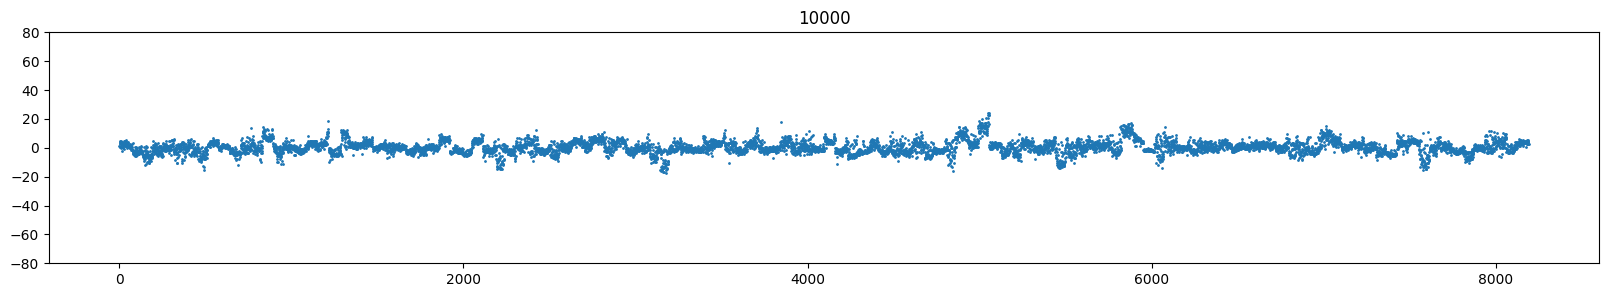

In [ ]:
vector_dict = torch.load('experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_0/12/vector_dict.json', map_location=torch.device('cpu'), weights_only=True)

for key in vector_dict.keys():
    c_vec = vector_dict[key]
    plot_vector(c_vec, key)

c_vec = torch.load('experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_0/12/concept_vectors_h_None.pt', map_location=torch.device('cpu'), weights_only=True)
plot_vector(c_vec, '10000')

### Evolution of accuracy

In [ ]:
dict_evolution_accuracy = {
    'seed 0 0': [0.97, 0.95, 0.91, 0.96, 0.91, 0.86, 0.93],
    'seed 0 1': [0.01, 0.87, 0.85, 0.84, 0.84, 0.87, 0.88],
    'seed 0 4': [0.00, 0.88, 0.91, 0.87, 0.90, 0.87, 0.87],
    'seed 0 6': [0.00, 0.85, 0.88, 0.80, 0.87, 0.88, 0.80],
    'seed 0 8': [0.00, 0.46, 0.79, 0.77, 0.80, 0.85, 0.82],
    'seed 0 10': [0.00, 0.73, 0.87, 0.91, 0.85, 0.88, 0.84],
    'seed 0 12': [0.00, 0.06, 0.35, 0.60, 0.67, 0.60, 0.59],
    'seed 0 15': [0.00, 0.14, 0.18, 0.46, 0.53, 0.55, 0.57],
    'seed 3 0': [0.98, 0.99, 0.97, 0.92, 0.93, 0.91, 0.93],
    'seed 3 1': [0.01, 0.73, 0.79, 0.88, 0.89, 0.87, 0.91],
    'seed 3 4': [0.01, 0.63, 0.78, 0.81, 0.85, 0.88, 0.86],
    'seed 3 6': [0.00, 0.16, 0.39, 0.72, 0.81, 0.77, 0.83],
    'seed 3 8': [0.00, 0.05, 0.53, 0.92, 0.89, 0.92, 0.84],
    'seed 3 10': [0.00, 0.72, 0.88, 0.83, 0.89, 0.89, 0.86],
    'seed 3 12': [0.00, 0.01, 0.01, 0.24, 0.37, 0.44, 0.34],
    'seed 3 15': [0.00, 0.03, 0.02, 0.15, 0.48, 0.58, 0.56]
}

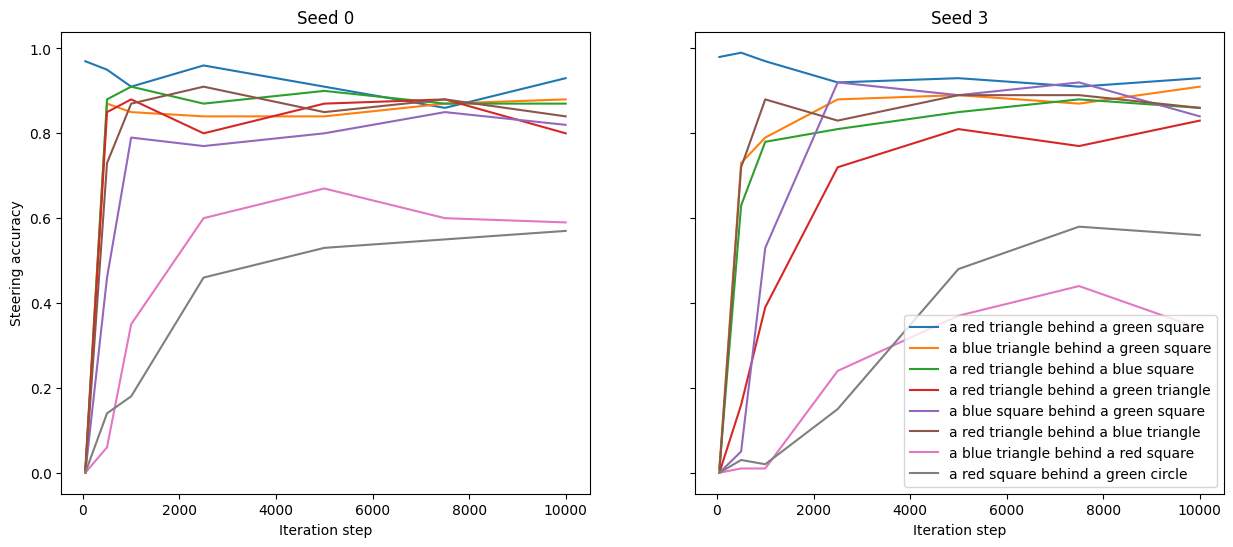

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

iteration_steps = [50, 500, 1000, 2500, 5000, 7500, 10000]

for i in [0, 1, 4, 6, 8, 10, 12, 15]:
    axes[0].plot(iteration_steps, dict_evolution_accuracy[f'seed 0 {i}'], label=df_accuracy['starting point'].iloc[i])

    axes[1].plot(iteration_steps, dict_evolution_accuracy[f'seed 3 {i}'], label=df_accuracy['starting point'].iloc[i])

axes[0].set_title('Seed 0')
axes[0].set_ylabel('Steering accuracy')
axes[0].set_xlabel('Iteration step')

axes[1].set_title('Seed 3')
axes[1].set_xlabel('Iteration step')

plt.legend()
plt.show()

Both seeds reflect similar patterns on the starting points. All cases will have a region of increase in the steering accuracy followed by a stabilisation period where the accuracy does not vary significantly but may increase or decrease slightly (this may relate to the stochasticity in convergence, where the loss does not fully stabilise but oscillates around a minimum). Some noticeable patterns:
1. When starting point = end point (blue line), the optimisation process can decrease the accuracy. In this case there is no mismatch between the prompt and the images generated. Additional steering on the end point may be leading to unnecessary modification of the outputs and potential overfitting to the images used to find the concept vector.
2. Some curves take longer to increase and converge at a lower accuracy. These both correspond to curves where 2 factors of $c_1, s_1, c_2, s_2$ are edited, however not all curves where 2 factors are edited have this issue (a blue square behind a green square and a red triangle behind a blue triangle also satisfy this and reach a high accuracy).

# Editing the concept vectors

## Zero largest/smallest entries

Results are presented for Seeds 0 and 3.

In [4]:
accuracy_dict_masked_smallest = {
    'proportion_masked': [0.00, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 1.0],
    'seed 0 0': [0.93, 0.84, 0.77, 0.88, 0.91, 0.97, 0.95, 0.96],
    'seed 0 1': [0.88, 0.86, 0.86, 0.80, 0.86, 0.45, 0.11, 0.00],
    'seed 0 4': [0.87, 0.88, 0.82, 0.74, 0.87, 0.59, 0.15, 0.00],
    'seed 0 6': [0.80, 0.82, 0.83, 0.81, 0.85, 0.27, 0.01, 0.00],
    'seed 0 8': [0.82, 0.78, 0.74, 0.81, 0.80, 0.62, 0.06, 0.00],
    'seed 0 10': [0.85, 0.81, 0.68, 0.80, 0.71, 0.46, 0.04, 0.00],
    'seed 0 12': [0.59, 0.44, 0.58, 0.51, 0.43, 0.21, 0.12, 0.00],
    'seed 0 15': [0.57, 0.55, 0.52, 0.47, 0.42, 0.06, 0.00, 0.00],
    'seed 3 0': [0.93, 0.92, 0.91, 0.91, 0.92, 0.90, 0.85, 0.90],
    'seed 3 1': [0.91, 0.82, 0.84, 0.87, 0.84, 0.72, 0.48, 0.00],
    'seed 3 4': [0.86, 0.82, 0.87, 0.87, 0.75, 0.60, 0.19, 0.00],
    'seed 3 6': [0.83, 0.78, 0.86, 0.81, 0.76, 0.39, 0.24, 0.00],
    'seed 3 8': [0.84, 0.87, 0.86, 0.87, 0.86, 0.60, 0.12, 0.00],
    'seed 3 10': [0.86, 0.90, 0.87, 0.80, 0.87, 0.64, 0.12, 0.00],
    'seed 3 12': [0.59, 0.36, 0.36, 0.34, 0.37, 0.03, 0.01, 0.00],
    'seed 3 15': [0.56, 0.56, 0.61, 0.57, 0.46, 0.18, 0.00, 0.00]
}

accuracy_dict_masked_largest = {
    'proportion_masked': [0.00, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 1.0],
    'seed 0 0': [0.93, 0.91, 0.85, 0.91, 0.92, 0.97, 0.94, 0.96],
    'seed 0 1': [0.88, 0.74, 0.59, 0.07, 0.00, 0.00, 0.00, 0.00],
    'seed 0 4': [0.87, 0.75, 0.40, 0.05, 0.00, 0.00, 0.00, 0.00],
    'seed 0 6': [0.80, 0.18, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    'seed 0 8': [0.82, 0.39, 0.12, 0.00, 0.00, 0.00, 0.00, 0.00],
    'seed 0 10': [0.85, 0.62, 0.29, 0.05, 0.00, 0.00, 0.00, 0.00],
    'seed 0 12': [0.59, 0.04, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    'seed 0 15': [0.57, 0.33, 0.13, 0.00, 0.00, 0.00, 0.00, 0.00],
    'seed 3 0': [0.93, 0.98, 0.97, 0.96, 0.95, 0.97, 0.90, 0.90],
    'seed 3 1': [0.91, 0.49, 0.13, 0.00, 0.00, 0.00, 0.00, 0.00],
    'seed 3 4': [0.86, 0.61, 0.42, 0.04, 0.00, 0.00, 0.00, 0.00],
    'seed 3 6': [0.83, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    'seed 3 8': [0.84, 0.50, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00],
    'seed 3 10': [0.86, 0.59, 0.06, 0.00, 0.00, 0.00, 0.00, 0.00],
    'seed 3 12': [0.59, 0.03, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    'seed 3 15': [0.56, 0.08, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]
}

In [10]:
def plot_masking_accuracies(dict_accuracies, order='largest'):    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)
    fig.suptitle(f'Accuracies for different proportion of {order} entries zeroed')
    
    for i in [0, 1, 4, 6, 8, 10, 12, 15]:
        axes[0].plot(dict_accuracies['proportion_masked'], dict_accuracies[f'seed 0 {i}'], label=df_accuracy['starting point'].iloc[i])
    
        axes[1].plot(dict_accuracies['proportion_masked'], dict_accuracies[f'seed 3 {i}'], label=df_accuracy['starting point'].iloc[i])
    
    axes[0].set_title('Seed 0')
    axes[0].set_ylabel('Steering accuracy')
    axes[0].set_xlabel('Proportion masked')
    
    axes[1].set_title('Seed 3')
    axes[1].set_xlabel('Proportion masked')
    
    plt.legend()
    plt.show()

Below are the results for masking the largest and smallest entries in the concept vector (according to absolute value of the entry).

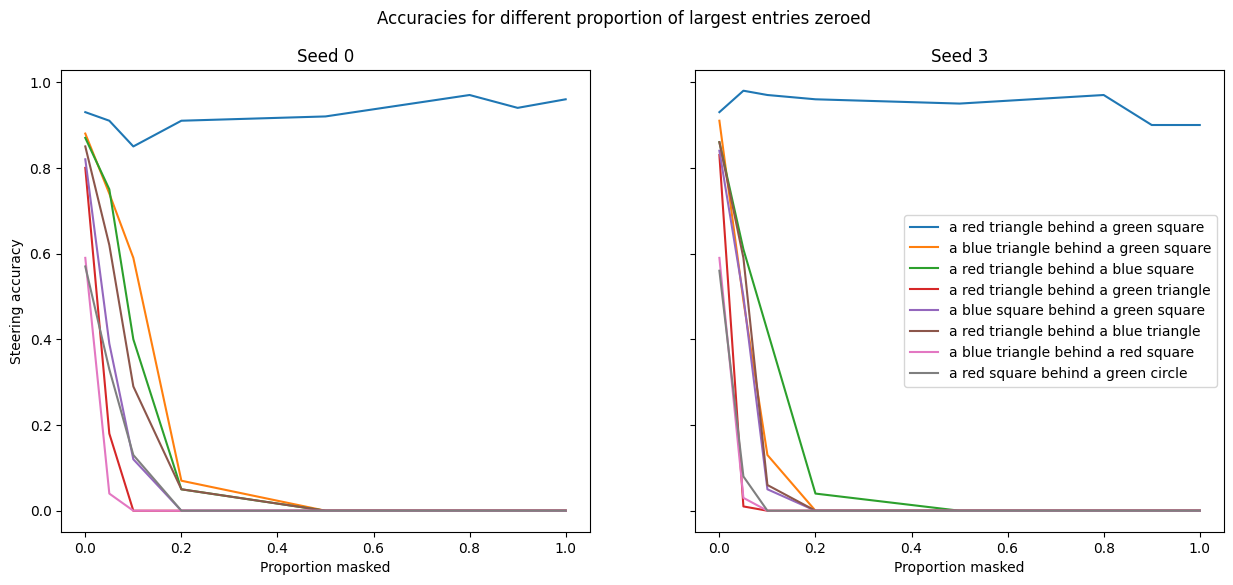

In [11]:
plot_masking_accuracies(accuracy_dict_masked_largest, order='largest')

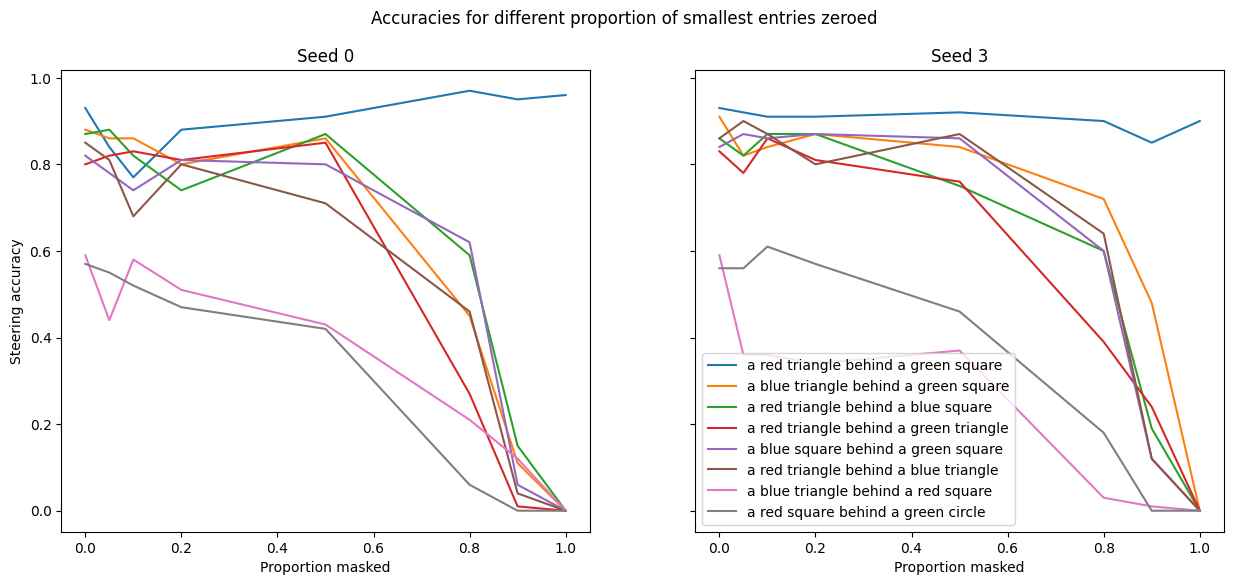

In [12]:
plot_masking_accuracies(accuracy_dict_masked_smallest, order='smallest')

Excluding the case start prompt = end prompt (blue line), which remains unaffected by masking the concept vector, it can be seen that the largest entries in the concept vector are esssential to the steerability of the direction. Zeroing the top 5% largest values has a significant impact on accuracy, and as the proportion of zeroed entries is increased, the steering accuracy rapidly declines. In contrast, up to half of the (smallest) entries in the concept vector can be zeroed and still obtain a significant steering accuracy (it could be argued that the smaller entries being set to 0 is not so radically different to setting large values to 0). It is worth noting that the steering accuracy in this case is almost unaffected by zeroing the vector.

## Normalise

Implemented the following transformations on the $h$-space concept vector:
1. Min-max normalisation (scale values between $[0,1]$)
$$
v^* = \frac{v - v_{\min}}{v_{\max} - v_{\min}},
$$
where $v_{\min} = \min(v)$ and $v_{\max} = \max(v)$ are the smallest and largest entries of $v$ respectively.
2. L2 normalisation (norm value $1$)
$$
v^* = \frac{v}{\|v\|}
$$
3. Standardisation (centre at mean 0 with standard deviation 1)
$$
v^* = \frac{v - \mu(v)}{\sigma(v)},
$$
where $\mu$ is the mean and $\sigma$ the standard deviation of the entries of $v$.

Transformations 1. and 2. do not produce any change in the start prompt (the generation process seems to be unaffected and just generates images with the description of the starting prompt). 3. Seems to produce some minor edits - a small number of images may change to the description of the end point. Results for this are presented below.

In [4]:
accuracy_dict_stand = {
    'seed 0': [0.93, 0.18, 0.06, 0.00, 0.10, 0.10, 0.04, 0.29, 0.23, 0.19, 0.27, 0.00, 0.01, 0.00, 0.00, 0.00, 0.00],
    'seed 1': [0.89, 0.17, 0.02, 0.01, 0.20, 0.31, 0.02, 0.05, 0.03, 0.44, 0.51, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    'seed 2': [0.95, 0.01, 0.00, 0.00, 0.01, 0.07, 0.00, 0.00, 0.00, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    'seed 3': [0.98, 0.29, 0.04, 0.01, 0.14, 0.02, 0.00, 0.13, 0.08, 0.28, 0.01, 0.00, 0.08, 0.00, 0.00, 0.00, 0.00]
}

df_accuracy_stand = pd.DataFrame(accuracy_dict_stand)
df_accuracy_stand['starting point'] = df_accuracy['starting point']
df_accuracy_stand.index = df_accuracy['starting point']

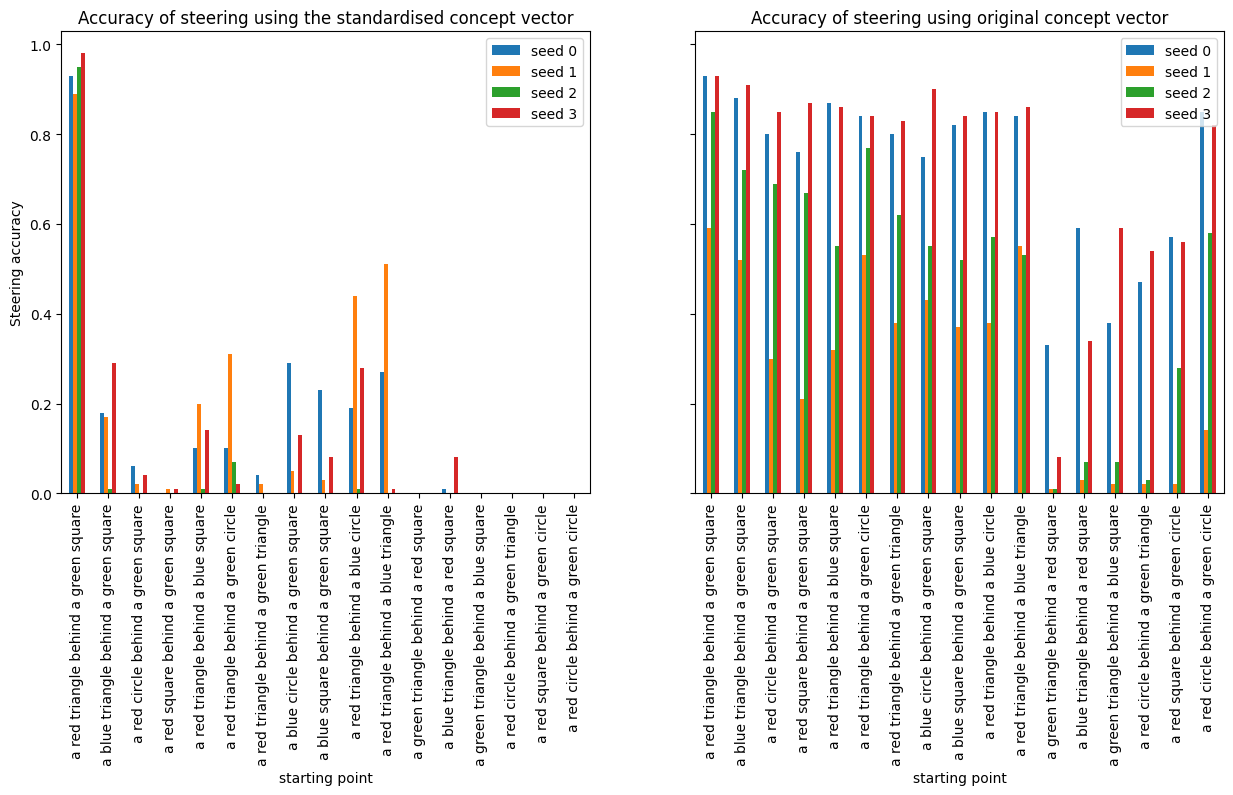

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharex=True, sharey=True)

df_accuracy_stand.plot(x='starting point', y=['seed 0', 'seed 1', 'seed 2', 'seed 3'], kind='bar', ax=axes[0])
df_accuracy.plot(x='starting point', y=['seed 0', 'seed 1', 'seed 2', 'seed 3'], kind='bar', ax=axes[1])

axes[0].set_title('Accuracy of steering using the standardised concept vector')
axes[0].set_ylabel('Steering accuracy')

axes[1].set_title('Accuracy of steering using original concept vector')

plt.show()

Steering accuracy on the standardised concept vector is worse than on the original concept vector. It is worth noting that Seed 1, which obtains the worst steering accuracy using the original concept vector at times outperforms the other random seeds when steering with the standardised vector.

# Prompt space comparison to ground truth

This refers to steering on the prompt space, not $h$-space, as above. By prompt space this refers to the encoding of the prompt before being inputted into the cross-attention layer of the U-net.

## Steering accuracy for different random seeds

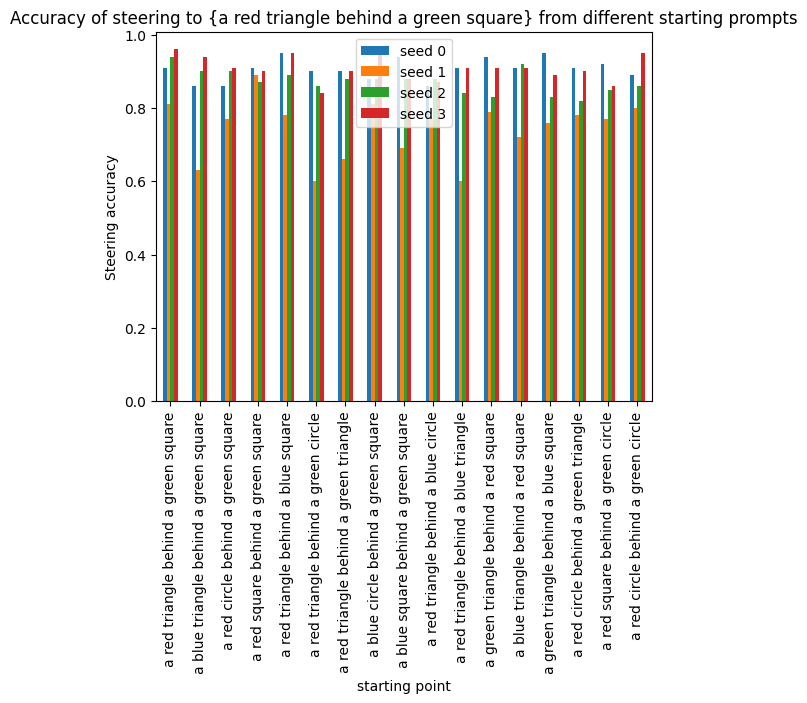

In [ ]:
accuracy_dict_prompt = {
    'starting point': ['a red triangle behind a green square','a blue triangle behind a green square', 'a red circle behind a green square', 'a red square behind a green square', 'a red triangle behind a blue square', 'a red triangle behind a green circle', 'a red triangle behind a green triangle', 'a blue circle behind a green square', 'a blue square behind a green square', 'a red triangle behind a blue circle', 'a red triangle behind a blue triangle', 'a green triangle behind a red square', 'a blue triangle behind a red square', 'a green triangle behind a blue square', 'a red circle behind a green triangle', 'a red square behind a green circle', 'a red circle behind a green circle'],
    'seed 0': [0.91, 0.86, 0.86, 0.91, 0.95, 0.90, 0.90, 0.88, 0.94, 0.86, 0.91, 0.94, 0.91, 0.95, 0.91, 0.92, 0.89],
    'seed 1': [0.81, 0.63, 0.77, 0.89, 0.78, 0.60, 0.66, 0.81, 0.69, 0.77, 0.60, 0.79, 0.72, 0.76, 0.78, 0.77, 0.80],
    'seed 2': [0.94, 0.90, 0.90, 0.87, 0.89, 0.86, 0.88, 0.88, 0.88, 0.88, 0.84, 0.83, 0.92, 0.83, 0.82, 0.85, 0.86],
    'seed 3': [0.96, 0.94, 0.91, 0.90, 0.95, 0.84, 0.90, 0.95, 0.88, 0.87, 0.91, 0.91, 0.91, 0.89, 0.90, 0.86, 0.95]
}

df_accuracy_prompt = pd.DataFrame(accuracy_dict_prompt)

df_accuracy_prompt.plot(x='starting point', y=['seed 0', 'seed 1', 'seed 2', 'seed 3'], kind='bar')
plt.ylabel('Steering accuracy')
plt.title('Accuracy of steering to {a red triangle behind a green square} from different starting prompts')
plt.show()

Accuracy for Seed 0, Seed 2 and Seed 3 is quite good.

## Comparison of obtained concept vectors on prompt space and ground truth

The vectors on the prompt space are of size 10x512, so can be visualised as a 3d surface, where the $z$ value of the surface is the entry of the vector.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def visualise_prompt_vectors(index):
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(20, 20), subplot_kw={'projection': '3d'})

    for i in range(2):
        vector = torch.load(f'experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_{i}/{index}/concept_vectors_p_None.pt', map_location=torch.device('cpu'), weights_only=True).detach().numpy()

        x=np.arange(vector[0].shape[1])
        y=np.arange(vector[0].shape[0])
        x, y = np.meshgrid(x, y)

        #print(x)
        #print(y)

        axes[0, i].plot_surface(x, y, vector[0], cmap=cm.coolwarm)
        axes[0, i].set_title(f'Seed {i}')
        axes[0, i].view_init(azim=30, elev=20)

        vector = torch.load(f'experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_{i + 2}/{index}/concept_vectors_p_None.pt', map_location=torch.device('cpu'), weights_only=True).detach().numpy()

        x=np.arange(vector[0].shape[1])
        y=np.arange(vector[0].shape[0])
        x, y = np.meshgrid(x, y)

        axes[1, i].plot_surface(x, y, vector[0], cmap=cm.coolwarm)
        axes[1, i].set_title(f'Seed {i+2}')
        axes[1, i].view_init(azim=30, elev=20)

    plt.show()


In [ ]:
def plot_ground_truth(ground_truth, title):
    x=np.arange(ground_truth[0].shape[1])
    y=np.arange(ground_truth[0].shape[0])
    x, y = np.meshgrid(x, y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, ground_truth[0], cmap=cm.coolwarm)
    ax.set_title(title)
    ax.view_init(elev=20, azim=30)

    plt.show()


### Example: a blue triangle behind a green square

Below is the vector that is found between the prompt encoding of the starting point (a blue triangle behind a green square) and the end point (a red triangle behind a green square). Note that the prompts only differ in $c_1$, so the majority of the concept vector is close to 0.

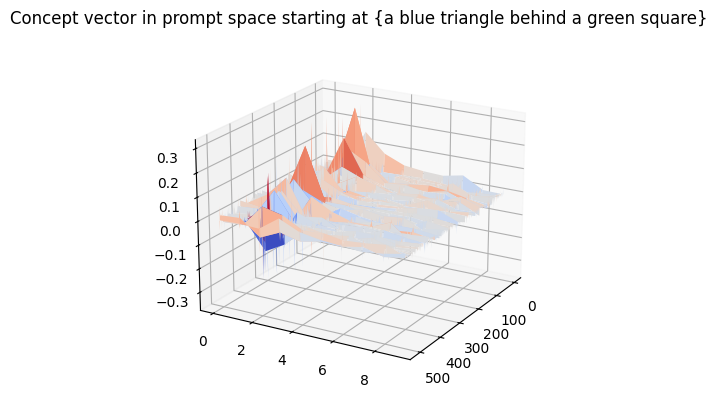

In [ ]:
ground_truth = torch.load('experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_0/1/ground_truth_p.pt', map_location=torch.device('cpu'), weights_only=True).detach().numpy()
plot_ground_truth(ground_truth, 'Concept vector in prompt space starting at {a blue triangle behind a green square}')

Below is the concept vectors obtained for the 4 different random seeds, all obtaining a relatively high steering accuracy (excluding seed 1). Overall there are no clear patterns and the plots are difficult to understand, but it is clear that the vectors are not similar to the ground truth. Also note the difference in magnitude ($z$-axis range).

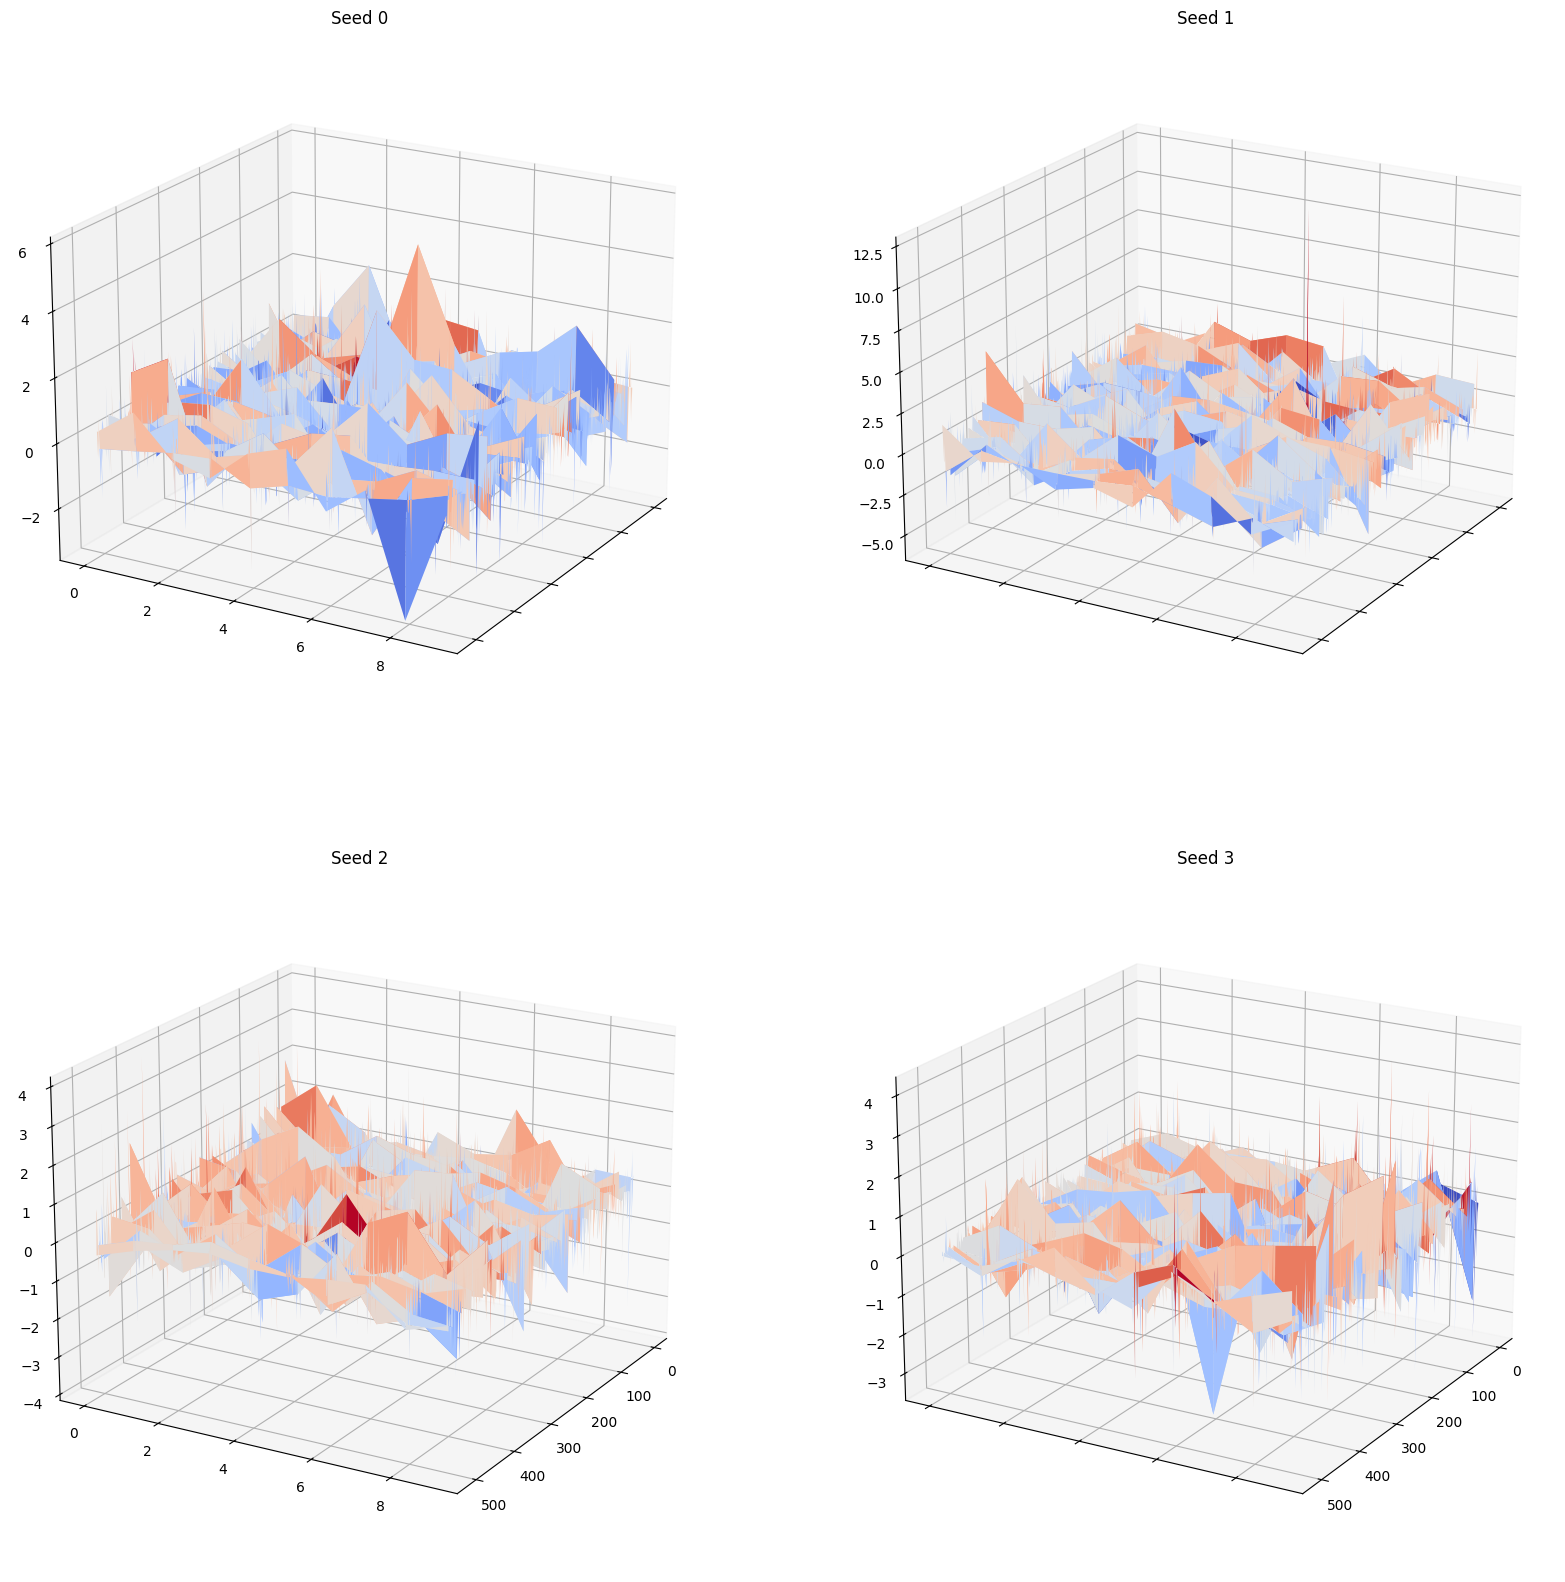

In [ ]:
visualise_prompt_vectors(1)

### Example: a red triangle behind a blue triangle

Same problem as before, in this case the vector compares the staring prompt (a red triangle behind a red triangle) and end prompt (a red triangle behind a green triangle). The values of a few regions of the vector are also close to zero.

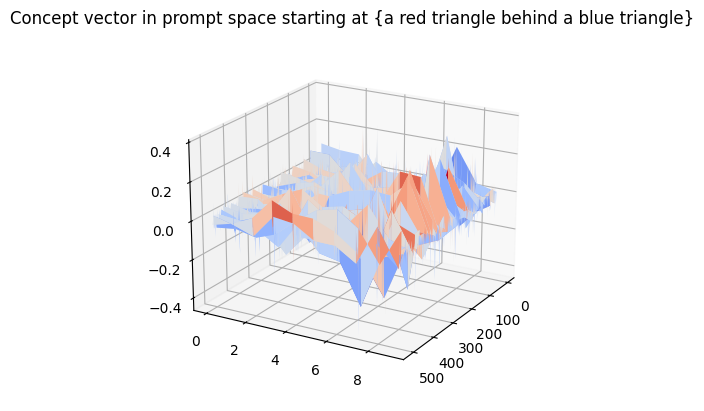

In [ ]:
ground_truth = torch.load('experiment_2/diffusion_b_adam_0.001_normal_complete_dataset/seed_0/10/ground_truth_p.pt', map_location=torch.device('cpu'), weights_only=True).detach().numpy()
plot_ground_truth(ground_truth, 'Concept vector in prompt space starting at {a red triangle behind a blue triangle}')

The optimised vectors are very different to the above.

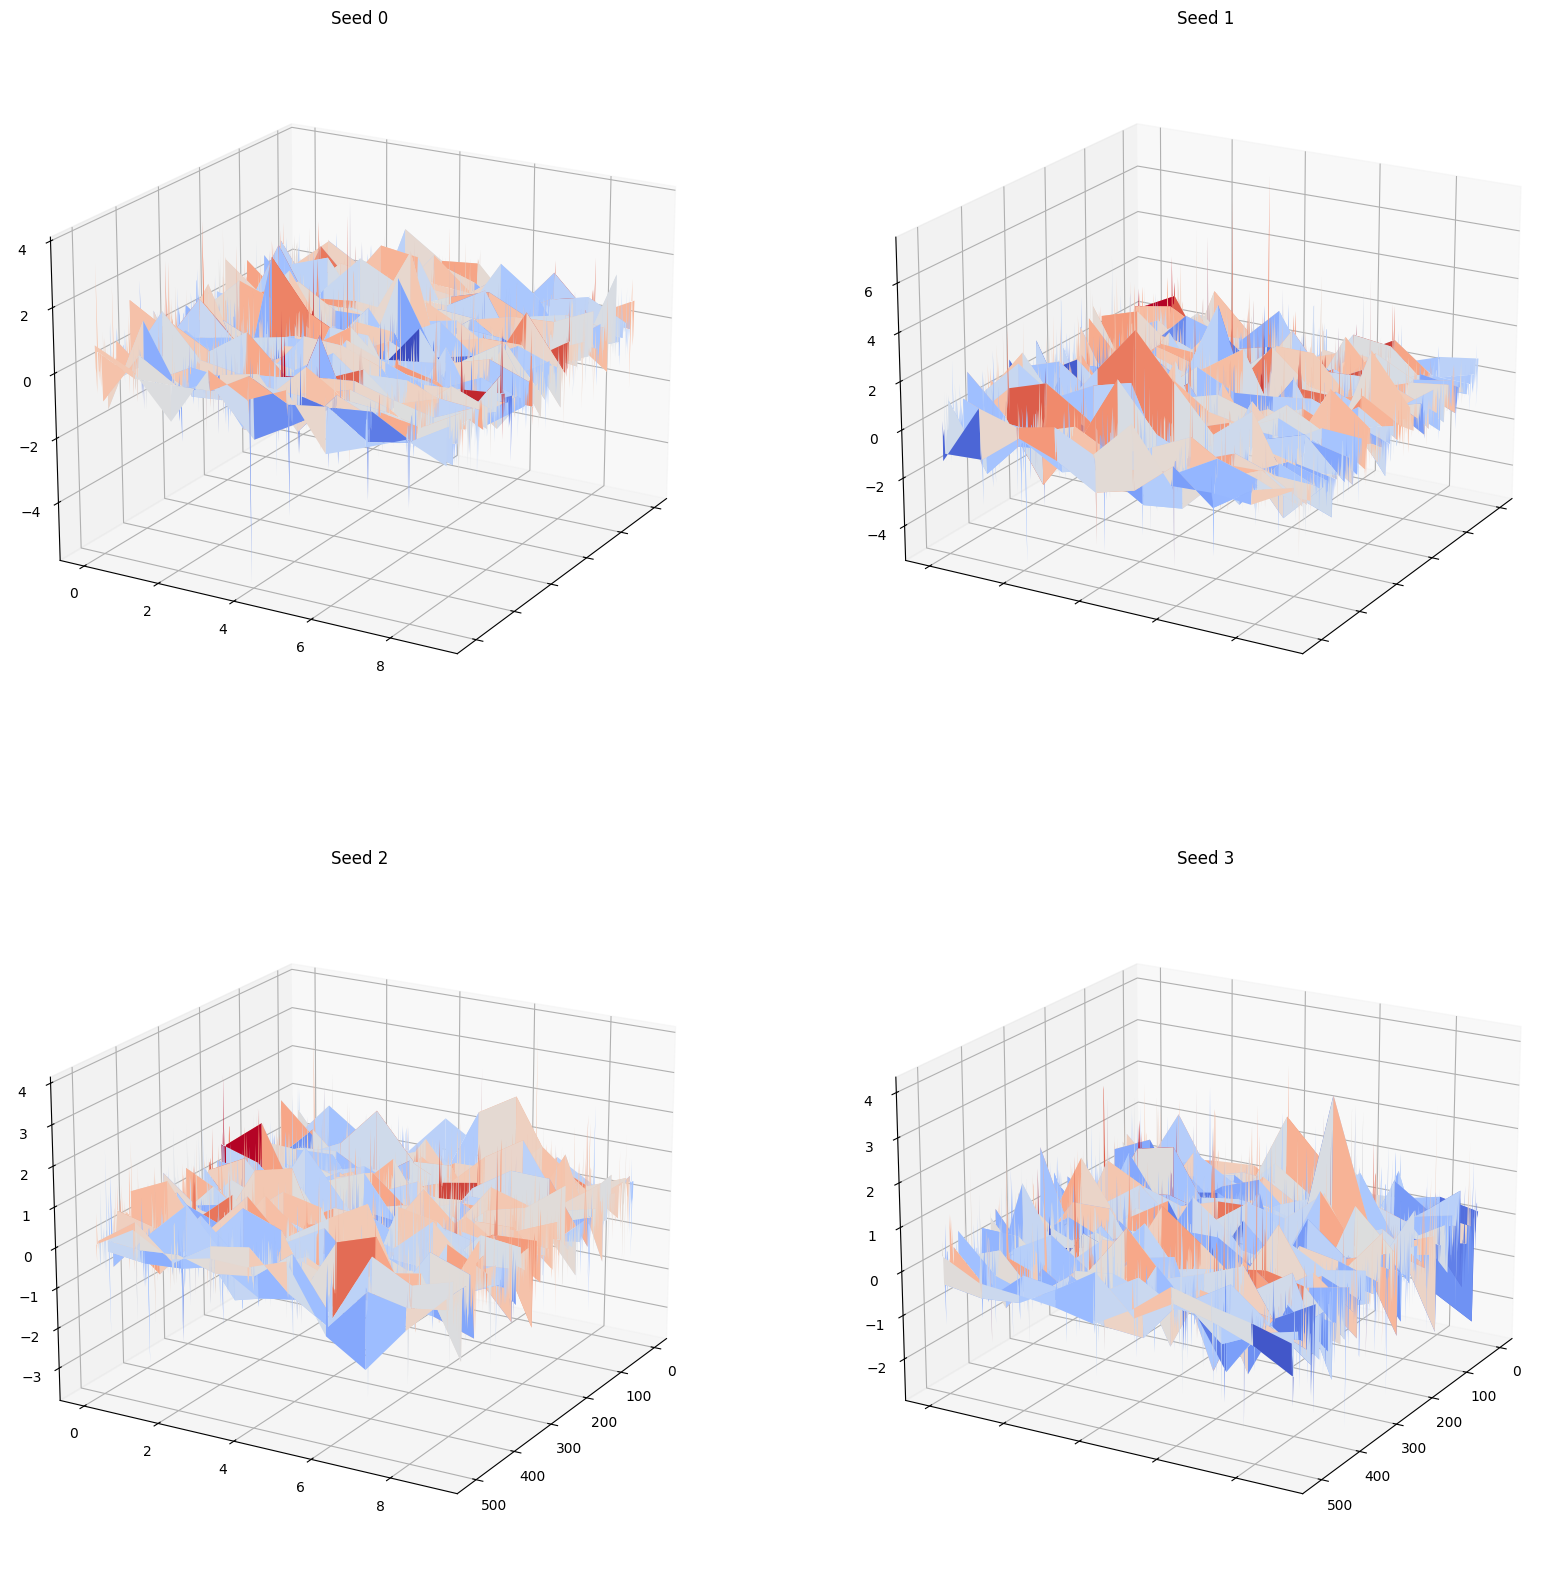

In [ ]:
visualise_prompt_vectors(10)